# RQ1

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy.spatial.distance import cdist
from scipy.stats import pearsonr, spearmanr
import warnings

# Suppress warnings for cleaner notebook output
warnings.filterwarnings('ignore')

class NYCPedBikeNexus:
    def __init__(self, ped_df, bike_df, dist_threshold=400):
        """
        Initializes the analysis.
        
        Args:
            ped_df: The wide-format NYC Bi-Annual Pedestrian Counts
            bike_df: The raw Citibike Trip Data (filtered to relevant months)
            dist_threshold: Meters to consider a 'match' (Default 400m ~ 5 min walk)
        """
        self.ped_raw = ped_df
        self.bike_raw = bike_df
        self.threshold = dist_threshold
        
        # Storage for processed data
        self.ped_long = None
        self.bike_agg = None
        self.merged_data = None
        self.correlations = None

    def preprocess_pedestrian(self):
        """
        Melts the wide NYC Pedestrian data into a long format 
        and parses the 'MonthYear_Period' headers.
        """
        print("Step 1: Cleaning Pedestrian Data...")
        df = self.ped_raw.copy()
        
        # 1. Identify columns that contain count data (e.g., May22_AM, June24_MD)
        # Regex explanation: Starts with letters, ends with 2 digits, underscore, then Period
        count_cols = [c for c in df.columns if re.match(r'^[A-Za-z]+\d{2}_[A-Za-z]+$', c)]
        
        # 2. Melt from Wide to Long
        id_vars = [c for c in df.columns if c not in count_cols]
        df_long = df.melt(id_vars=id_vars, value_vars=count_cols, 
                          var_name='period_code', value_name='ped_count')
        
        # 3. Parse the 'period_code' (e.g., 'May22_pM' -> Month: May, Year: 2022, Period: PM)
        def parse_code(code):
            # Extract Month, Year, Period (handling case insensitivity like pM)
            match = re.match(r'([A-Za-z]+)(\d{2})_([A-Za-z]+)', code)
            if match:
                month_str, year_str, period = match.groups()
                return month_str, int("20" + year_str), period.upper()
            return None, None, None

        parsed = df_long['period_code'].apply(lambda x: pd.Series(parse_code(x)))
        df_long[['month_name', 'year', 'period']] = parsed
        
        # 4. Map Month Names to Numbers for easier sorting/matching
        month_map = {'May': 5, 'June': 6, 'Jun': 6, 'Sept': 9, 'Oct': 10}
        df_long['month'] = df_long['month_name'].map(month_map)
        
        # 5. Extract Lat/Lon from Geometry if needed (Assuming 'the_geom' exists)
        # If your CSV already has Lat/Lon columns, skip this. 
        # Here we assume a robust extraction from the 'the_geom' POINT string.
        if 'the_geom' in df_long.columns and 'lat' not in df_long.columns:
            df_long['clean_geom'] = df_long['the_geom'].astype(str).str.extract(r'POINT \(([-0-9.]+) ([-0-9.]+)\)')[1] # Extract Lat
            df_long['lat'] = df_long['the_geom'].astype(str).str.extract(r'POINT \(([-0-9.]+) ([-0-9.]+)\)')[1].astype(float)
            df_long['lon'] = df_long['the_geom'].astype(str).str.extract(r'POINT \(([-0-9.]+) ([-0-9.]+)\)')[0].astype(float)

        self.ped_long = df_long.dropna(subset=['ped_count', 'lat', 'lon'])
        print(f"   -> Processed {len(self.ped_long)} pedestrian observation records.")
        return self.ped_long

    def preprocess_bikeshare(self):
        """
        Aggregates bikeshare data specifically into AM/PM/MD windows 
        to match the pedestrian count methodology.
        """
        print("Step 2: Aggregating Bikeshare Data (Peaks Only)...")
        df = self.bike_raw.copy()
        
        # Convert times
        df['started_at'] = pd.to_datetime(df['started_at'])
        df['date'] = df['started_at'].dt.date
        df['hour'] = df['started_at'].dt.hour
        df['month'] = df['started_at'].dt.month
        df['year'] = df['started_at'].dt.year
        
        # Define NYC DOT Peak Windows
        # AM: 7-9, MD: 11-1 (11-13), PM: 4-7 (16-19)
        def get_period(hour):
            if 7 <= hour < 10: return 'AM'
            if 11 <= hour < 14: return 'MD'
            if 16 <= hour < 20: return 'PM'
            return 'OFF'

        df['period'] = df['hour'].apply(get_period)
        
        # Filter strictly to peak hours to reduce noise and size
        df = df[df['period'] != 'OFF']
        
        # We need to count ACTIVITY (Starts + Ends) at a location
        # Count Starts
        starts = df.groupby(['start_station_name', 'start_lat', 'start_lng', 'year', 'month', 'period']).size().reset_index(name='starts')
        starts.rename(columns={'start_station_name':'station', 'start_lat':'lat', 'start_lng':'lon'}, inplace=True)
        
        # Count Ends
        ends = df.groupby(['end_station_name', 'end_lat', 'end_lng', 'year', 'month', 'period']).size().reset_index(name='ends')
        ends.rename(columns={'end_station_name':'station', 'end_lat':'lat', 'end_lng':'lon'}, inplace=True)
        
        # Merge and Sum
        # Note: We group by Station Name to avoid slight lat/lon drift issues in CitiBike data
        total = pd.merge(starts, ends, on=['station', 'lat', 'lon', 'year', 'month', 'period'], how='outer').fillna(0)
        total['bike_activity'] = total['starts'] + total['ends']
        
        # Average lat/lon for the station to clean up drift
        self.bike_agg = total.groupby(['station', 'year', 'month', 'period']).agg({
            'lat': 'mean', 'lon': 'mean', 'bike_activity': 'sum'
        }).reset_index()
        
        print(f"   -> Aggregated into {len(self.bike_agg)} station-period-month observation buckets.")
        return self.bike_agg

    def spatial_join_and_merge(self):
        """
        Performs the spatial join between Pedestrian counters and Bike Stations,
        then merges the temporal data.

        In addition to the matched spatiotemporal pairs (self.merged_data),
        this also stores unmatched pedestrian locations (self.unmatched_ped)
        where no bikeshare station is found within the distance threshold box.
        """
        print("Step 3: Spatial Join & Temporal Merge...")
        
        ped_locs = self.ped_long[['Loc', 'Street_Nam', 'lat', 'lon']].drop_duplicates()
        bike_locs = self.bike_agg[['station', 'lat', 'lon']].drop_duplicates()
        
        merged_rows = []
        unmatched_locs = set()

        # Approximate lat/lon threshold for your distance in meters
        # 1 deg lat ~ 111km; 400m ~ 0.0036 deg. We keep your 0.005 for safety.
        latlon_thresh = 0.005  

        for _, p_row in ped_locs.iterrows():
            nearby_bikes = bike_locs[
                (np.abs(bike_locs['lat'] - p_row['lat']) < latlon_thresh) & 
                (np.abs(bike_locs['lon'] - p_row['lon']) < latlon_thresh)
            ]
            
            if nearby_bikes.empty:
                unmatched_locs.add(p_row['Loc'])
                continue
                
            relevant_bike_data = self.bike_agg[self.bike_agg['station'].isin(nearby_bikes['station'])]
            p_data = self.ped_long[self.ped_long['Loc'] == p_row['Loc']]
            
            merged = pd.merge(p_data, relevant_bike_data, on=['year', 'month', 'period'], how='inner')
            
            if not merged.empty:
                # Bring through ped lat/lon (all rows for a given Loc have identical coordinates)
                merged['ped_lat'] = merged['lat_x'] if 'lat_x' in merged else merged['lat']
                merged['ped_lon'] = merged['lon_x'] if 'lon_x' in merged else merged['lon']

                final_obs = merged.groupby([
                    'Loc', 'Street_Nam', 'year', 'month', 'period', 'ped_count'
                ]).agg({
                    'bike_activity': 'sum',
                    'station': 'count',
                    'ped_lat': 'mean',
                    'ped_lon': 'mean'
                }).reset_index()

                final_obs.rename(columns={'ped_lat':'lat', 'ped_lon':'lon'}, inplace=True)

                merged_rows.append(final_obs)

        if merged_rows:
            self.merged_data = pd.concat(merged_rows, ignore_index=True)
            print(f"   -> Successfully matched {len(self.merged_data)} spatiotemporal data points.")
        else:
            self.merged_data = None
            print("   -> No matches found. Check your lat/lon coordinates.")
        
        # Store all unmatched pedestrian observations (all periods/years at those Locs)
        if unmatched_locs:
            self.unmatched_ped = self.ped_long[self.ped_long['Loc'].isin(unmatched_locs)].copy()
            print(f"   -> {self.unmatched_ped['Loc'].nunique()} pedestrian locations have NO nearby stations.")
        else:
            self.unmatched_ped = pd.DataFrame()
            print("   -> All pedestrian locations have at least one nearby station.")

        return self.merged_data


    def analyze_rq1(self):
        """
        Calculates Pearson and Spearman correlations.
        """
        print("Step 4: Running RQ1 Analysis...")
        data = self.merged_data
        
        # Global Correlation
        pearson_r, p_val = pearsonr(data['ped_count'], data['bike_activity'])
        spearman_r, s_val = spearmanr(data['ped_count'], data['bike_activity'])
        
        print("\n" + "="*40)
        print("RQ1 RESULTS: GLOBAL CORRELATION")
        print("="*40)
        print(f"Pearson r  : {pearson_r:.4f} (Linear Relationship)")
        print(f"Spearman r : {spearman_r:.4f} (Rank Relationship)")
        print(f"Sample Size: {len(data)}")
        
        # Plotting
        plt.figure(figsize=(10, 6))
        sns.scatterplot(data=data, x='ped_count', y='bike_activity', hue='period', alpha=0.6)
        sns.regplot(data=data, x='ped_count', y='bike_activity', scatter=False, color='black')
        plt.title(f'RQ1: Pedestrian Traffic vs Bikeshare Activity\n(Pearson r={pearson_r:.2f})')
        plt.xlabel('Pedestrian Count (Peak Period)')
        plt.ylabel('Total Bikeshare Turnover (Starts+Ends)')
        plt.grid(True, alpha=0.3)
        plt.show()
        
        return data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
import contextily as ctx # For basemaps if available, otherwise we stick to scatter

# Settings for academic-style plots
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['figure.dpi'] = 150

class DatasetDeepDive:
    def __init__(self, ped_long_df, bike_agg_df, merged_df):
        """
        Expects the CLEANED dataframes from the previous step.
        """
        self.ped = ped_long_df
        self.bike = bike_agg_df
        self.merged = merged_df
        
        # Color palette for consistency
        self.colors = {'AM': '#1f77b4', 'MD': '#ff7f0e', 'PM': '#2ca02c'}
        self._enriched_cache = None  # NEW

    def get_enriched_merged(self, min_ped=50):
        """
        Returns a version of self.merged with:
        - conversion_rate (bike_activity / ped_count)
        - z_ped, z_bike (within-period z-scores)
        - gap_score (z_ped - z_bike)

        min_ped: drop very low pedestrian counts to avoid unstable ratios.
        """
        if self.merged is None:
            raise ValueError("merged_df is None. Run spatial_join_and_merge() first.")

        if self._enriched_cache is not None:
            return self._enriched_cache.copy()

        df = self.merged.copy()
        df = df[df['ped_count'] > min_ped].reset_index(drop=True)

        # Conversion rate: trips per pedestrian
        df['conversion_rate'] = df['bike_activity'] / df['ped_count']

        # Period-wise z-scores
        df['z_ped'] = df.groupby('period')['ped_count'].transform(
            lambda x: (x - x.mean()) / x.std(ddof=0)
        )
        df['z_bike'] = df.groupby('period')['bike_activity'].transform(
            lambda x: (x - x.mean()) / x.std(ddof=0)
        )

        # Gap score: positive = high ped relative to bike; negative = high bike relative to ped
        df['gap_score'] = df['z_ped'] - df['z_bike']

        self._enriched_cache = df
        return df.copy()
    
    def zscore_table(self, top_n=10, min_ped=50):
        """
        Returns two tables:
        - Ghost zones (high ped, low bike)
        - Workhorse nodes (low ped, high bike)

        Aggregated at Location × Period level.
        """

        df = self.get_enriched_merged(min_ped=min_ped)

        # Aggregate to stable reporting unit
        summary = (
            df.groupby(['Loc', 'period'], as_index=False)
            .agg({
                'ped_count': 'mean',
                'bike_activity': 'mean',
                'z_ped': 'mean',
                'z_bike': 'mean',
                'gap_score': 'mean'
            })
        )

        ghosts = summary.sort_values('gap_score', ascending=False).head(top_n)
        workhorses = summary.sort_values('gap_score', ascending=True).head(top_n)

        return ghosts, workhorses


    # ==========================================
    # LAYER 1: THE PEDESTRIAN SIGNAL (DEMAND)
    # ==========================================
    def analyze_pedestrian_distributions(self):
        """
        Generates descriptive stats and plots for the Pedestrian Count data.
        Goal: Show that data is non-normal (skewed) and spatially varied.
        """
        print(">>> Generating Pedestrian Distribution Analysis...")
        
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        
        # 1. Distribution Histogram (Log Scale)
        # Why: Pedestrian data usually follows a Power Law. Most streets are quiet; a few are Times Square.
        sns.histplot(self.ped['ped_count'], bins=50, kde=True, ax=axes[0], color='salmon')
        axes[0].set_title('Distribution of Pedestrian Counts (All Obs)')
        axes[0].set_xlabel('Pedestrians per Period')
        
        # 2. Counts by Period (AM vs MD vs PM)
        # Why: Validate that PM is actually the peak.
        sns.boxplot(data=self.ped, x='period', y='ped_count', ax=axes[1], palette=self.colors, showfliers=False)
        axes[1].set_title('Volume Intensity by Time of Day')
        axes[1].set_ylabel('Pedestrian Count (Outliers Removed)')
        
        # 3. Borough Breakdown (If Borough column exists, otherwise skip)
        if 'Borough' in self.ped.columns:
            order = self.ped.groupby('Borough')['ped_count'].median().sort_values(ascending=False).index
            sns.barplot(data=self.ped, x='Borough', y='ped_count', estimator=np.median, order=order, ax=axes[2], palette='viridis')
            axes[2].set_title('Median Traffic by Borough')
            axes[2].tick_params(axis='x', rotation=45)
            
        plt.tight_layout()
        plt.show()
        
        # Textual Stat Summary
        print("\n[Pedestrian Stats]")
        print(self.ped['ped_count'].describe().to_markdown())
        print(f"Skewness: {self.ped['ped_count'].skew():.2f} (High skew > 1 indicates 'Super-Hubs' exist)")

    def analyze_temporal_recovery(self):
        """
        Checks Year-over-Year trends (2022-2024).
        Goal: Check if 2024 data is significantly different from 2022 (Post-COVID Recovery).
        """
        print("\n>>> Generating Temporal Trend Analysis...")
        
        # Group by Year and Period
        trend = self.ped.groupby(['year', 'period'])['ped_count'].mean().reset_index()
        
        plt.figure(figsize=(10, 5))
        sns.lineplot(data=trend, x='year', y='ped_count', hue='period', marker='o', palette=self.colors, linewidth=2.5)
        plt.title('Year-over-Year Average Pedestrian Volume (2022-2024)')
        plt.xticks([2022, 2023, 2024])
        plt.ylabel('Avg Pedestrian Count')
        plt.grid(True, alpha=0.3)
        plt.show()

    # ==========================================
    # LAYER 2: THE BIKESHARE SIGNAL (SUPPLY/USE)
    # ==========================================
    def analyze_station_inequality(self):
        """
        Analyzes how usage is distributed across stations.
        Goal: Show the 'Lorenz Curve' of bikeshare. Do 20% of stations get 80% of trips?
        """
        print("\n>>> Generating Bikeshare Usage Inequality Analysis...")
        
        # Aggregate total activity per station across all times
        station_totals = self.bike.groupby('station')['bike_activity'].sum().sort_values(ascending=False).values
        
        # Lorenz Curve Calculation
        lorenz = np.cumsum(station_totals) / station_totals.sum()
        lorenz = np.insert(lorenz, 0, 0)
        
        # Perfect equality line
        perfect = np.linspace(0, 1, len(lorenz))
        
        plt.figure(figsize=(8, 6))
        plt.plot(np.linspace(0, 1, len(lorenz)), lorenz, label='Actual Usage Distribution', color='purple', linewidth=3)
        plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Perfect Equality')
        plt.title('Lorenz Curve: Bikeshare Station Inequality')
        plt.xlabel('Fraction of Stations (Sorted by Volume)')
        plt.ylabel('Fraction of Total Trips')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
        
        # Gini Coefficient
        gini = (np.abs(lorenz - perfect).sum()) / len(lorenz) / 0.5
        print(f"\n[Bikeshare Stats] Gini Coefficient: {gini:.3f}")
        print("Interpretaion: Higher Gini (>0.6) means the network relies heavily on a few 'Mega-Stations'.")

    # ==========================================
    # LAYER 3: JOINT ANALYSIS (CORRELATION DEEP DIVE)
    # ==========================================
    def analyze_segmented_correlations(self):
        """
        Breaks down the correlation by Period and Borough.
        Goal: Prove that the relationship isn't just noise; it's consistent across contexts.
        """
        print("\n>>> Generating Segmented Correlation Analysis...")
        
        # 1. By Period
        periods = ['AM', 'MD', 'PM']
        r_values = []
        for p in periods:
            sub = self.merged[self.merged['period'] == p]
            if len(sub) > 10:
                r, _ = pearsonr(sub['ped_count'], sub['bike_activity'])
                r_values.append(r)
            else:
                r_values.append(0)
                
        # 2. By Borough (if available in merged data)
        # Assuming we can map 'Loc' or 'Station' to Borough if not present
        # For now, we stick to Period which is guaranteed
        
        plt.figure(figsize=(8, 5))
        bars = plt.bar(periods, r_values, color=['#1f77b4', '#ff7f0e', '#2ca02c'], alpha=0.8, edgecolor='black')
        plt.ylim(0, 1.0)
        plt.axhline(0.6, color='red', linestyle='--', alpha=0.5, label='Strong Correlation Threshold')
        plt.title('Pearson Correlation (r) by Time of Day')
        plt.ylabel('Correlation Coefficient')
        plt.bar_label(bars, fmt='%.2f')
        plt.legend()
        plt.show()

    def analyze_the_efficiency_ratio(self):
        """
        Calculates 'Trips per Pedestrian' Ratio.
        """
        print("\n>>> Generating 'Conversion Efficiency' Analysis...")
        
        df = self.get_enriched_merged(min_ped=50)

        plt.figure(figsize=(10, 6))
        sns.histplot(df['conversion_rate'], bins=40, kde=True, color='teal')
        plt.title('Distribution of Pedestrian-to-Bike Conversion Rates')
        plt.xlabel('Bike Trips per Pedestrian')
        plt.axvline(df['conversion_rate'].median(), color='red', linestyle='--',
                    label=f'Median: {df['conversion_rate'].median():.2f}')
        plt.legend()
        plt.show()
        
        print("\n[Conversion Insight]")
        print("This chart defines 'normal'. Locations far to the left are under-performing;")
        print("locations far to the right are hyper-efficient / strong connectors.")
        

    def analyze_structural_mismatches(self, top_n=10):
        """
        IDENTIFYING THE GAPS (The Repositioning Guide).
        Uses z-scores to find stations where Supply/Demand are out of sync.
        Returns ghost_df and workhorse_df for algorithmic use.
        """
        print("\n>>> Layer 4: Structural Mismatch Identification (Z-Score Analysis)...")
        
        df = self.get_enriched_merged(min_ped=50)

        ghosts = df.sort_values('gap_score', ascending=False).head(top_n)
        workhorses = df.sort_values('gap_score', ascending=True).head(top_n)
        
        print(f"\n[TOP {top_n} 'GHOST ZONES' (High Ped / Low Bike)]")
        print(f"{'Location':<40} | {'Period':<6} | {'Ped Count':<10} | {'Bike Trips':<10} | {'Gap Score'}")
        print("-" * 90)
        for _, row in ghosts.iterrows():
            if 'Loc' in row and pd.notna(row['Loc']):
                loc_str = str(row['Loc'])
            elif 'Street_Nam' in row and pd.notna(row['Street_Nam']):
                loc_str = str(row['Street_Nam'])
            else:
                loc_str = "Unknown"

            loc = loc_str[:40]
            print(f"{loc:<40} | {row['period']:<6} | {row['ped_count']:<10.0f} | {row['bike_activity']:<10.0f} | {row['gap_score']:.2f}")

        print(f"\n[TOP {top_n} 'WORKHORSE NODES' (Low Ped / High Bike)]")
        print(f"{'Location':<40} | {'Period':<6} | {'Ped Count':<10} | {'Bike Trips':<10} | {'Gap Score'}")
        print("-" * 90)
        for _, row in workhorses.iterrows():
            if 'Loc' in row and pd.notna(row['Loc']):
                loc_str = str(row['Loc'])
            elif 'Street_Nam' in row and pd.notna(row['Street_Nam']):
                loc_str = str(row['Street_Nam'])
            else:
                loc_str = "Unknown"

            loc = loc_str[:40]
            print(f"{loc:<40} | {row['period']:<6} | {row['ped_count']:<10.0f} | {row['bike_activity']:<10.0f} | {row['gap_score']:.2f}")

        # Visualizing the Gaps
        plt.figure(figsize=(10, 6))
        sns.scatterplot(data=df, x='z_ped', y='z_bike', hue='period', alpha=0.6, palette=self.colors)
        
        min_val = min(df['z_ped'].min(), df['z_bike'].min())
        max_val = max(df['z_ped'].max(), df['z_bike'].max())
        plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Balanced Line')
        
        plt.title('Z-Score Mismatch: Supply vs. Demand Deviations')
        plt.xlabel('Pedestrian Intensity (Z-Score)')
        plt.ylabel('Bikeshare Intensity (Z-Score)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

        return ghosts, workhorses
    
    def identify_latent_demand_percentile(self, ped_q=0.9, bike_q=0.3):
        """
        Identifies locations / periods where:
        - pedestrian volume is in the top ped_q percentile
        - bike_activity is in the bottom bike_q percentile

        These are 'latent demand' zones: high foot traffic, low bikeshare usage.
        Returns a dataframe sorted by gap_score (highest unmet demand first).
        """
        print("\n>>> Identifying Latent Demand Zones (Percentile-based)...")

        df = self.get_enriched_merged(min_ped=50)

        ped_thr = df['ped_count'].quantile(ped_q)
        bike_thr = df['bike_activity'].quantile(bike_q)

        latent = df[(df['ped_count'] >= ped_thr) & (df['bike_activity'] <= bike_thr)].copy()
        latent = latent.sort_values('gap_score', ascending=False)

        print(f"   -> Thresholds: ped_count >= {ped_thr:.1f} (q={ped_q}), "
              f"bike_activity <= {bike_thr:.1f} (q={bike_q})")
        print(f"   -> Found {len(latent)} high-ped / low-bike observations.")

        return latent
    
    def plot_latent_demand_map(self, latent_df, zoom_out=True):
        """
        Simple scatterplot map of latent demand locations.
        Assumes 'lat' and 'lon' columns exist in self.merged.
        """
        if latent_df.empty:
            print("No latent demand points to plot.")
            return

        plt.figure(figsize=(8, 8))
        plt.scatter(self.merged['lon'], self.merged['lat'], s=5, alpha=0.2, label='All matched')
        plt.scatter(latent_df['lon'], latent_df['lat'], s=30, alpha=0.9, label='Latent Demand', marker='x')

        plt.title('High-Pedestrian / Low-Bikeshare Locations')
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.legend()
        plt.grid(True, alpha=0.3)

        try:
            import contextily as ctx
            ax = plt.gca()
            ctx.add_basemap(ax, crs="EPSG:4326")
        except Exception:
            pass  # if contextily not installed

        plt.show()



In [3]:
# --- Existing pipeline ---
ped_df = pd.read_csv('../../local/Data/nyc_foot/Bi-Annual_Pedestrian_Counts.csv')
bike_df = pd.read_csv('../../local/Data/PROCESSED/nyc/ped/citibike_selected_months_combined.csv') 

nexus = NYCPedBikeNexus(ped_df, bike_df, dist_threshold=400)
ped_long = nexus.preprocess_pedestrian()
bike_agg = nexus.preprocess_bikeshare()
merged = nexus.spatial_join_and_merge()

Step 1: Cleaning Pedestrian Data...
   -> Processed 11289 pedestrian observation records.
Step 2: Aggregating Bikeshare Data (Peaks Only)...
   -> Aggregated into 35313 station-period-month observation buckets.
Step 3: Spatial Join & Temporal Merge...
   -> Successfully matched 1463 spatiotemporal data points.
   -> 27 pedestrian locations have NO nearby stations.


In [5]:
# Create a lookup table
loc_lookup = (
    nexus.merged_data[['Loc', 'Street_Nam']]
    .drop_duplicates()
    .set_index('Loc')['Street_Nam']
    .to_dict()
)

## MIDDLE SECTION FOR DATA LOOKING, NOT ANALYSIS

In [5]:
# Basic descriptive table for the paper
summary = pd.DataFrame({
    "Feature": [
        "Pedestrian Source",
        "Bikeshare Source",
        "Temporal Resolution",
        "Spatial Match Threshold",
        "Total Matched Observations"
    ],
    "NYC (Sparse)": [
        "NYC DOT Bi-Annual Manual Counts",
        "CitiBike Trip Data (Starts+Ends)",
        "AM / MD / PM Windows",
        "400 meters",
        len(merged) if merged is not None else 0
    ],
    "DC (Continuous)": [
        "DC Automated Counters",
        "Capital Bikeshare Trip Data",
        "Hourly (24h)",
        "800 meters",
        "TBD"
    ]
})

print(summary.to_latex(index=False))


\begin{tabular}{lll}
\toprule
Feature & NYC (Sparse) & DC (Continuous) \\
\midrule
Pedestrian Source & NYC DOT Bi-Annual Manual Counts & DC Automated Counters \\
Bikeshare Source & CitiBike Trip Data (Starts+Ends) & Capital Bikeshare Trip Data \\
Temporal Resolution & AM / MD / PM Windows & Hourly (24h) \\
Spatial Match Threshold & 400 meters & 800 meters \\
Total Matched Observations & 1463 & TBD \\
\bottomrule
\end{tabular}



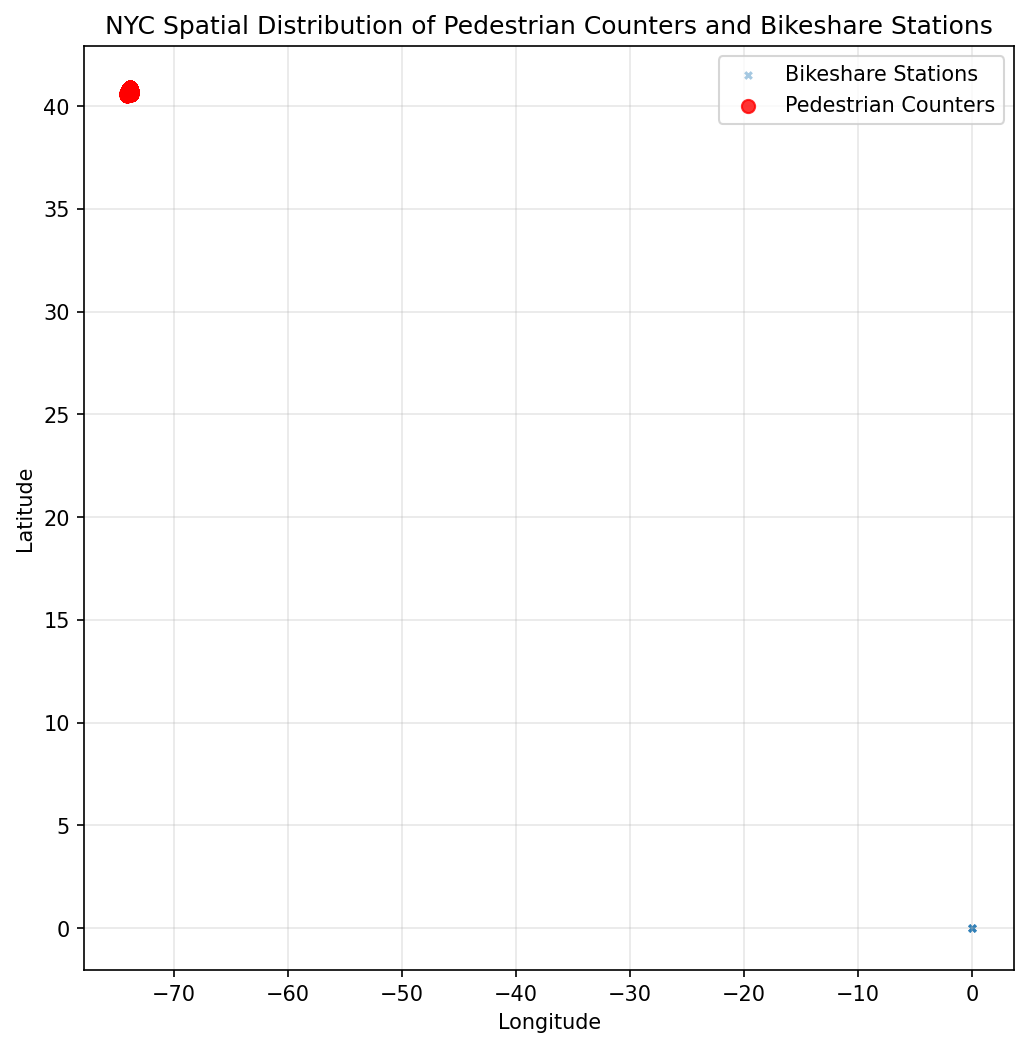

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))

# plot bike station locations
plt.scatter(bike_agg["lon"], bike_agg["lat"], 
            s=10, alpha=0.4, marker='x', label="Bikeshare Stations")

# plot pedestrian counters
plt.scatter(ped_long["lon"], ped_long["lat"], 
            s=40, alpha=0.8, color='red', label="Pedestrian Counters")

plt.title("NYC Spatial Distribution of Pedestrian Counters and Bikeshare Stations")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


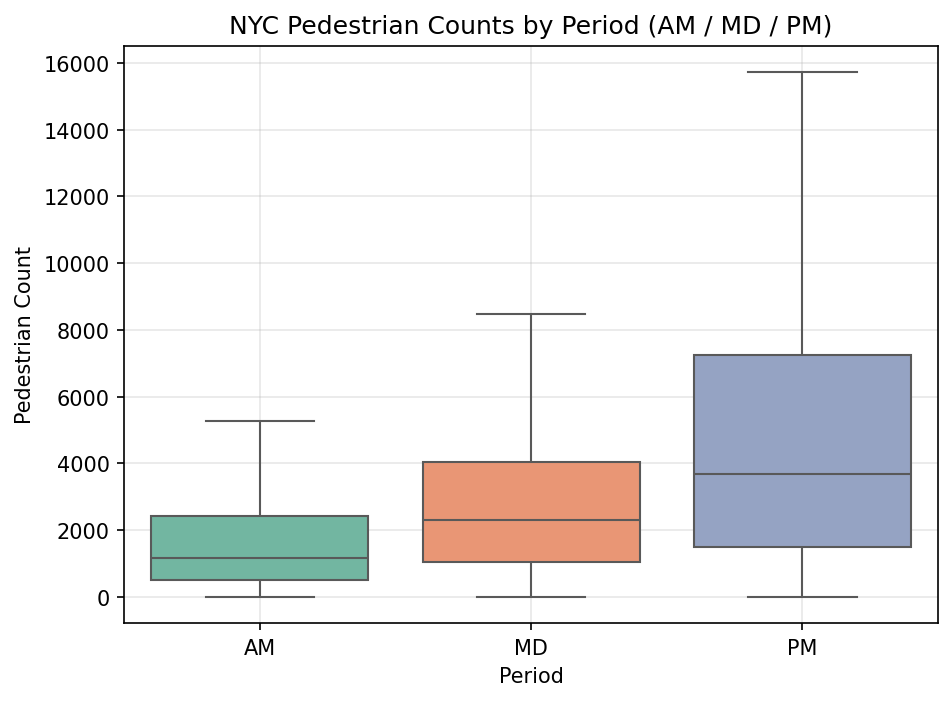

In [7]:
import seaborn as sns
plt.figure(figsize=(7,5))

sns.boxplot(data=ped_long, x="period", y="ped_count", 
            order=["AM","MD","PM"], 
            showfliers=False, palette="Set2")

plt.title("NYC Pedestrian Counts by Period (AM / MD / PM)")
plt.xlabel("Period")
plt.ylabel("Pedestrian Count")
plt.grid(alpha=0.3)
plt.show()


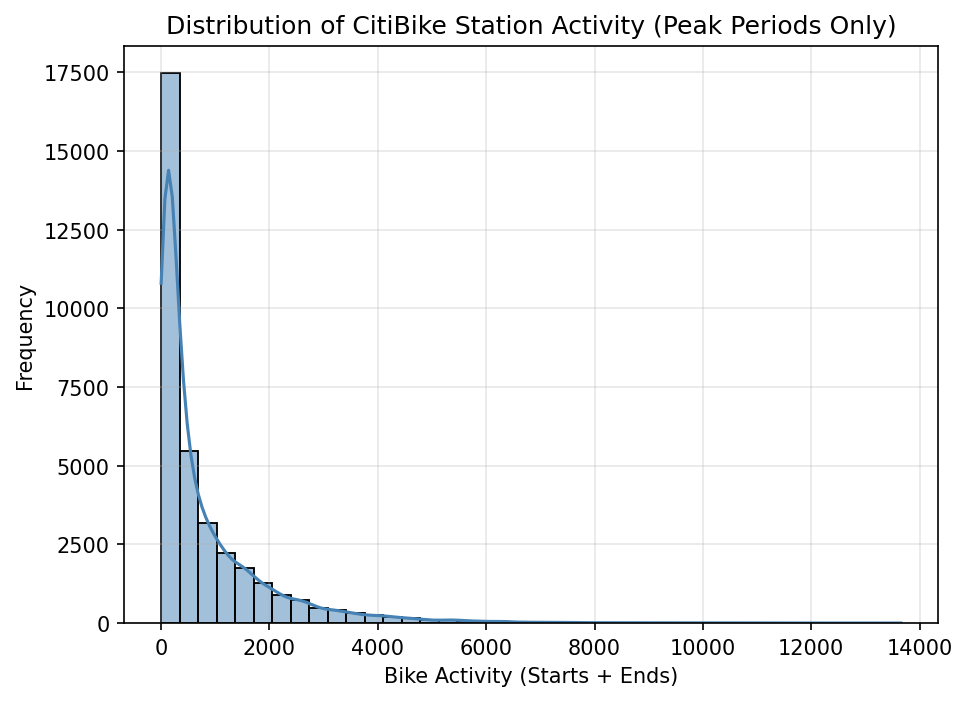

In [8]:
plt.figure(figsize=(7,5))
sns.histplot(bike_agg["bike_activity"], bins=40, kde=True, color="steelblue")

plt.title("Distribution of CitiBike Station Activity (Peak Periods Only)")
plt.xlabel("Bike Activity (Starts + Ends)")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.show()


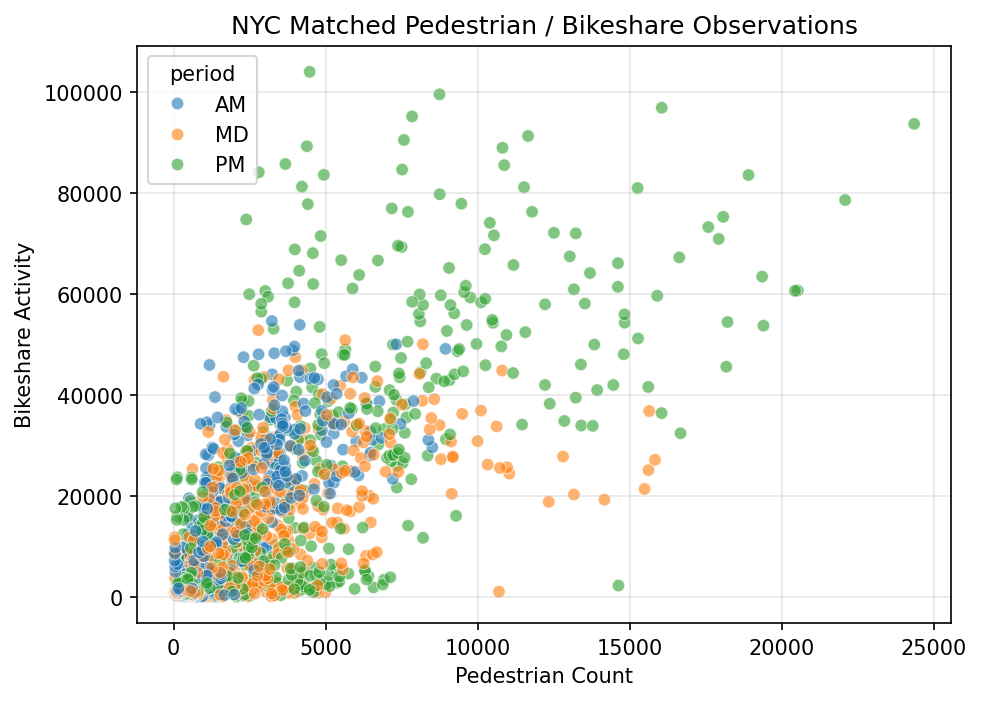

In [9]:
plt.figure(figsize=(7,5))

sns.scatterplot(
    data=merged, 
    x="ped_count", 
    y="bike_activity", 
    hue="period", 
    alpha=0.6
)

plt.title("NYC Matched Pedestrian / Bikeshare Observations")
plt.xlabel("Pedestrian Count")
plt.ylabel("Bikeshare Activity")
plt.grid(alpha=0.3)
plt.show()


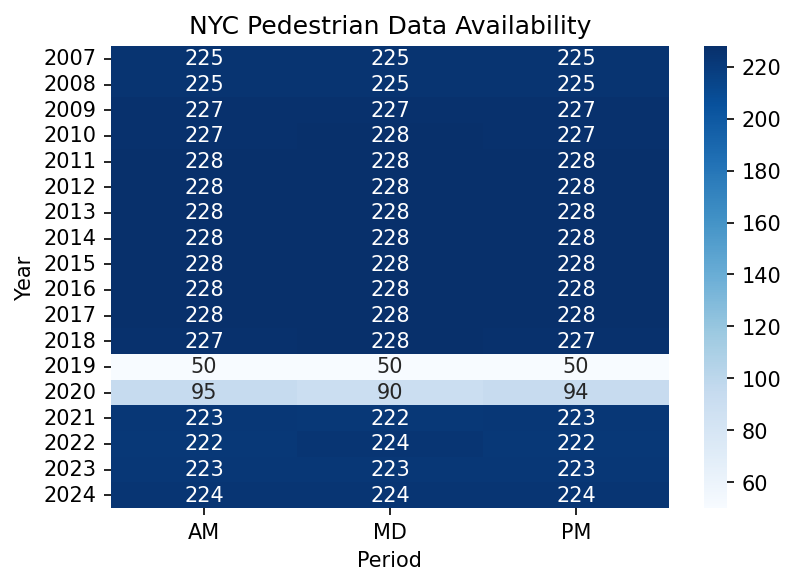

In [10]:
heat = ped_long.groupby(["year","period"]).size().unstack(fill_value=0)

plt.figure(figsize=(6,4))
sns.heatmap(heat, annot=True, cmap="Blues", fmt='d')

plt.title("NYC Pedestrian Data Availability")
plt.xlabel("Period")
plt.ylabel("Year")
plt.show()


Checking coordinate validity...
Ped lat range: 40.5711 to 40.8813
Ped lon range: -74.1661 to -73.7525
Bike lat range: 0.0000 to 40.8863
Bike lon range: -74.0867 to 0.0000

Filtered to valid NYC bounds:
  Pedestrian points: 11289 -> 11289
  Bike points: 35313 -> 35308


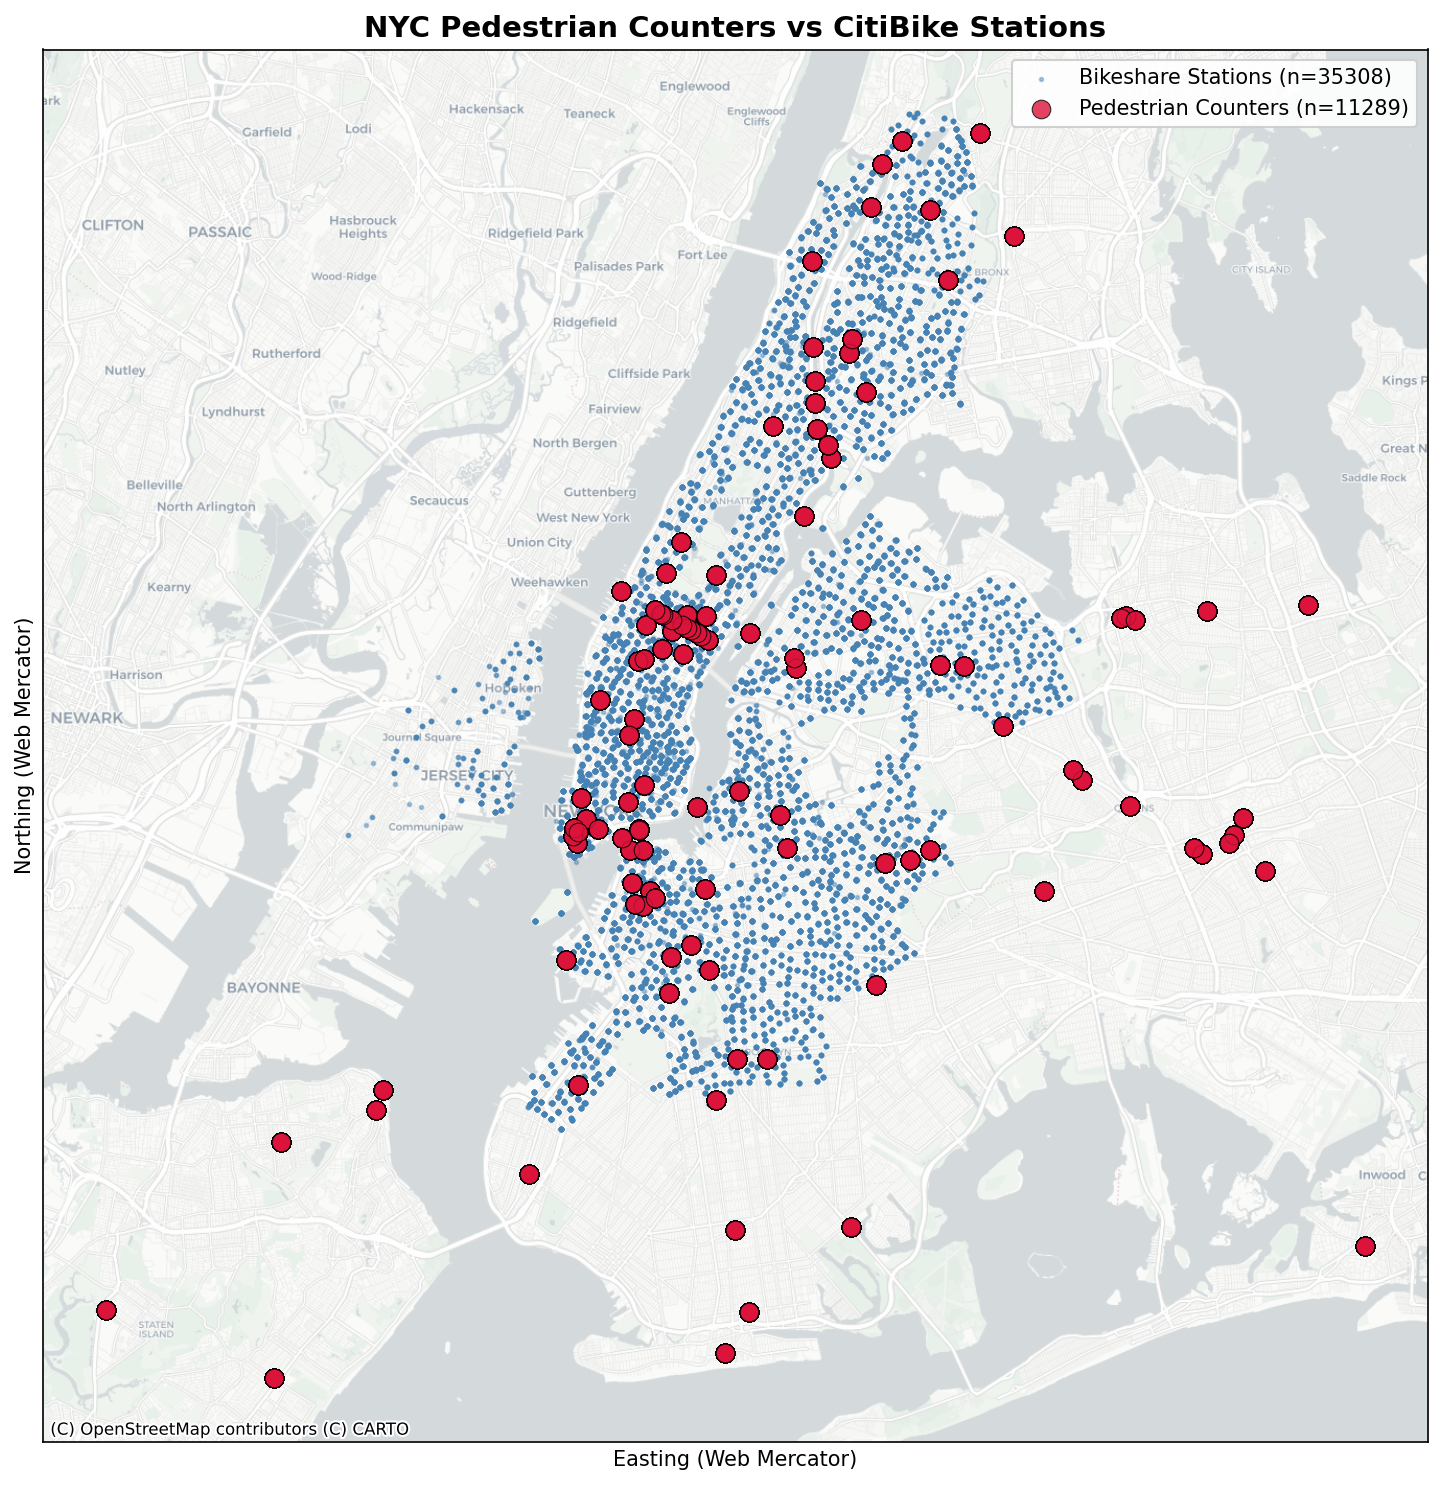

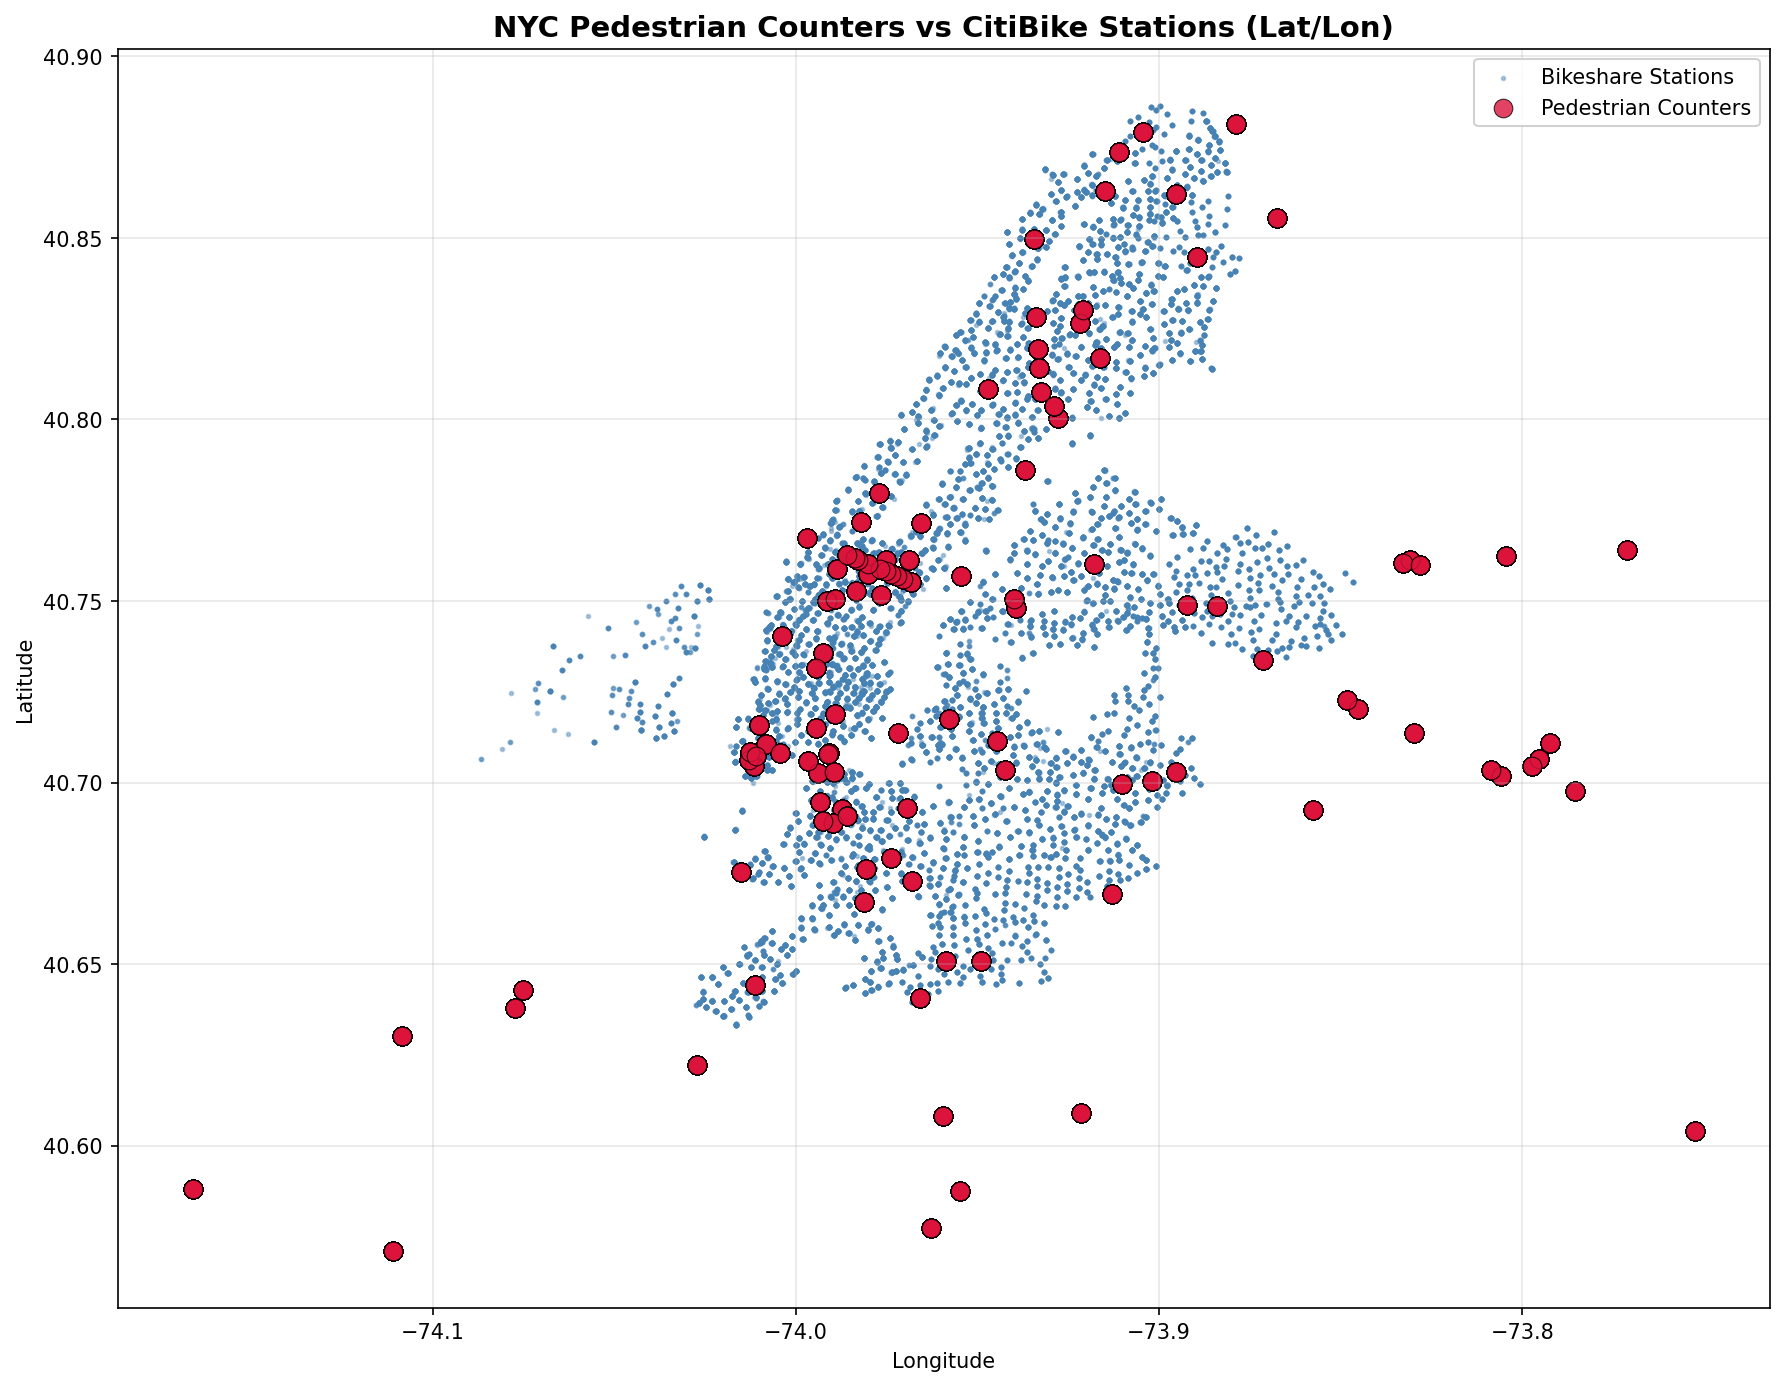

In [12]:
import matplotlib.pyplot as plt
import contextily as ctx
import geopandas as gpd
import numpy as np

# ============================================
# DIAGNOSTIC STEP 1: Check coordinate ranges
# ============================================
print("Checking coordinate validity...")
print(f"Ped lat range: {ped_long['lat'].min():.4f} to {ped_long['lat'].max():.4f}")
print(f"Ped lon range: {ped_long['lon'].min():.4f} to {ped_long['lon'].max():.4f}")
print(f"Bike lat range: {bike_agg['lat'].min():.4f} to {bike_agg['lat'].max():.4f}")
print(f"Bike lon range: {bike_agg['lon'].min():.4f} to {bike_agg['lon'].max():.4f}")

# NYC should be roughly: lat 40.5-41.0, lon -74.3 to -73.7
# If you see lat values around -74 or lon values around 40, THEY ARE SWAPPED

# ============================================
# QUICK FIX: Swap if needed (uncomment if swapped)
# ============================================
# Uncomment these lines if coordinates are swapped:
# ped_long['lat'], ped_long['lon'] = ped_long['lon'].copy(), ped_long['lat'].copy()
# bike_agg['lat'], bike_agg['lon'] = bike_agg['lon'].copy(), bike_agg['lat'].copy()

# ============================================
# FILTER VALID NYC COORDINATES
# ============================================
# Remove any points outside NYC bounds
nyc_lat_range = (40.4, 41.0)
nyc_lon_range = (-74.3, -73.7)

ped_valid = ped_long[
    (ped_long['lat'].between(*nyc_lat_range)) & 
    (ped_long['lon'].between(*nyc_lon_range))
].copy()

bike_valid = bike_agg[
    (bike_agg['lat'].between(*nyc_lat_range)) & 
    (bike_agg['lon'].between(*nyc_lon_range))
].copy()

print(f"\nFiltered to valid NYC bounds:")
print(f"  Pedestrian points: {len(ped_long)} -> {len(ped_valid)}")
print(f"  Bike points: {len(bike_agg)} -> {len(bike_valid)}")

# ============================================
# CREATE GEODATAFRAMES
# ============================================
g_ped = gpd.GeoDataFrame(
    ped_valid,
    geometry=gpd.points_from_xy(ped_valid['lon'], ped_valid['lat']),
    crs="EPSG:4326"
).to_crs("EPSG:3857")

g_bike = gpd.GeoDataFrame(
    bike_valid,
    geometry=gpd.points_from_xy(bike_valid['lon'], bike_valid['lat']),
    crs="EPSG:4326"
).to_crs("EPSG:3857")

# ============================================
# PLOT WITH CORRECT LABELS
# ============================================
fig, ax = plt.subplots(figsize=(12, 10))

# Plot bikeshare stations (dense network)
g_bike.plot(
    ax=ax, 
    markersize=3,  # Smaller since there are many
    color="steelblue", 
    marker='o', 
    alpha=0.4, 
    label=f"Bikeshare Stations (n={len(g_bike)})"
)

# Plot pedestrian counter locations (sparse)
g_ped.plot(
    ax=ax,
    markersize=80,  # Larger to stand out
    color="crimson",
    alpha=0.8,
    edgecolor='black',
    linewidth=0.5,
    label=f"Pedestrian Counters (n={len(g_ped)})"
)

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, zoom=12)

# Correct labels (we're in Web Mercator now)
ax.set_title("NYC Pedestrian Counters vs CitiBike Stations", fontsize=14, weight='bold')
ax.set_xlabel("Easting (Web Mercator)")
ax.set_ylabel("Northing (Web Mercator)")
ax.legend(loc='upper right', framealpha=0.9)

# Remove axis ticks for cleaner look
ax.set_xticks([])
ax.set_yticks([])

plt.tight_layout()
plt.show()

# ============================================
# ALTERNATIVE: Plot in original lat/lon (no basemap)
# ============================================
fig, ax = plt.subplots(figsize=(12, 10))

ax.scatter(bike_valid['lon'], bike_valid['lat'], 
           s=3, color='steelblue', alpha=0.4, label='Bikeshare Stations')
ax.scatter(ped_valid['lon'], ped_valid['lat'], 
           s=80, color='crimson', alpha=0.8, edgecolor='black', linewidth=0.5,
           label='Pedestrian Counters')

ax.set_title("NYC Pedestrian Counters vs CitiBike Stations (Lat/Lon)", 
             fontsize=14, weight='bold')
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend(loc='upper right', framealpha=0.9)
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')

plt.tight_layout()
plt.show()

ANALYSIS

     Loc period     ped_count  bike_activity     z_ped    z_bike  gap_score  \
172   65     MD  13619.666667   22092.166667  3.920291  0.658510   3.261781   
109   44     MD  12071.833333   29039.000000  3.346634  1.211981   2.134653   
147   57     AM   7885.500000   36495.500000  3.511825  1.620814   1.891011   
149   57     PM  20727.000000   71751.333333  3.529533  1.806668   1.722865   
173   65     PM  15072.833333   40436.333333  2.263939  0.545346   1.718594   

             Location  
172      Fifth Avenue  
109     Eighth Avenue  
147  West 34th Street  
149  West 34th Street  
173      Fifth Avenue  
>>> Generating Pedestrian Distribution Analysis...


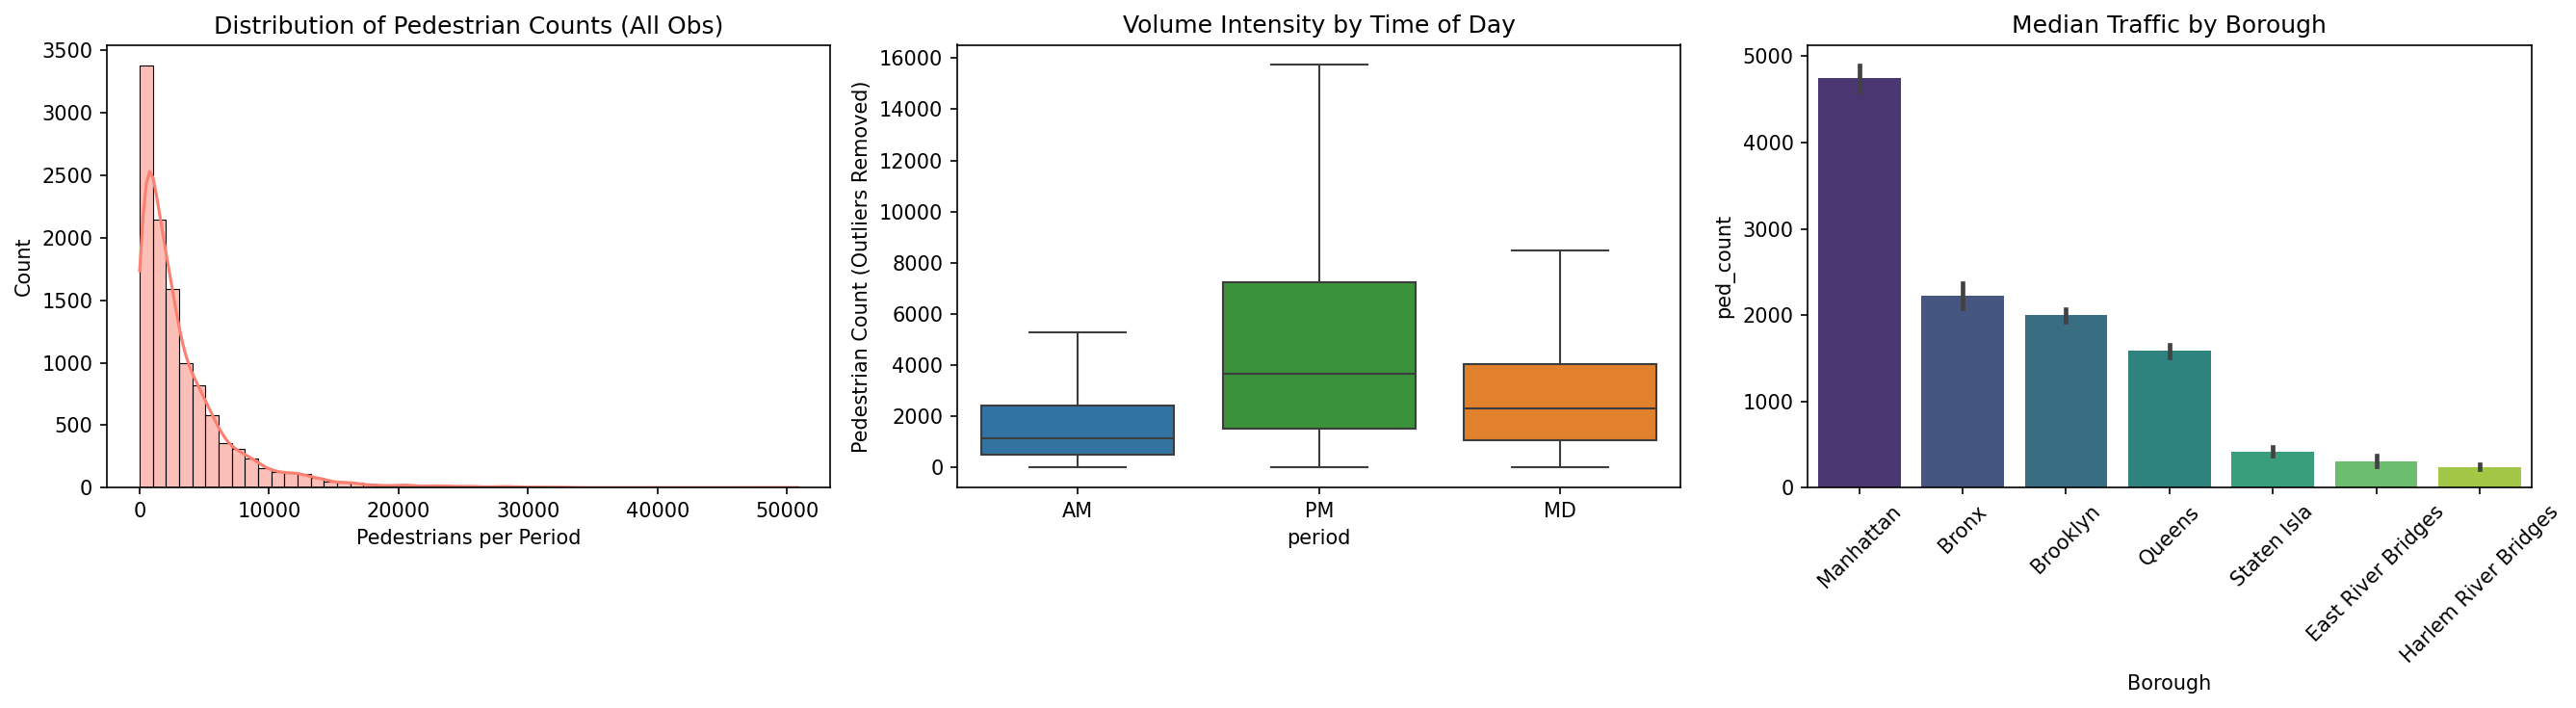


[Pedestrian Stats]
|       |   ped_count |
|:------|------------:|
| count |    11289    |
| mean  |     3407.85 |
| std   |     4058.75 |
| min   |        1    |
| 25%   |      795    |
| 50%   |     2097    |
| 75%   |     4484    |
| max   |    50827    |
Skewness: 2.79 (High skew > 1 indicates 'Super-Hubs' exist)

>>> Generating Temporal Trend Analysis...


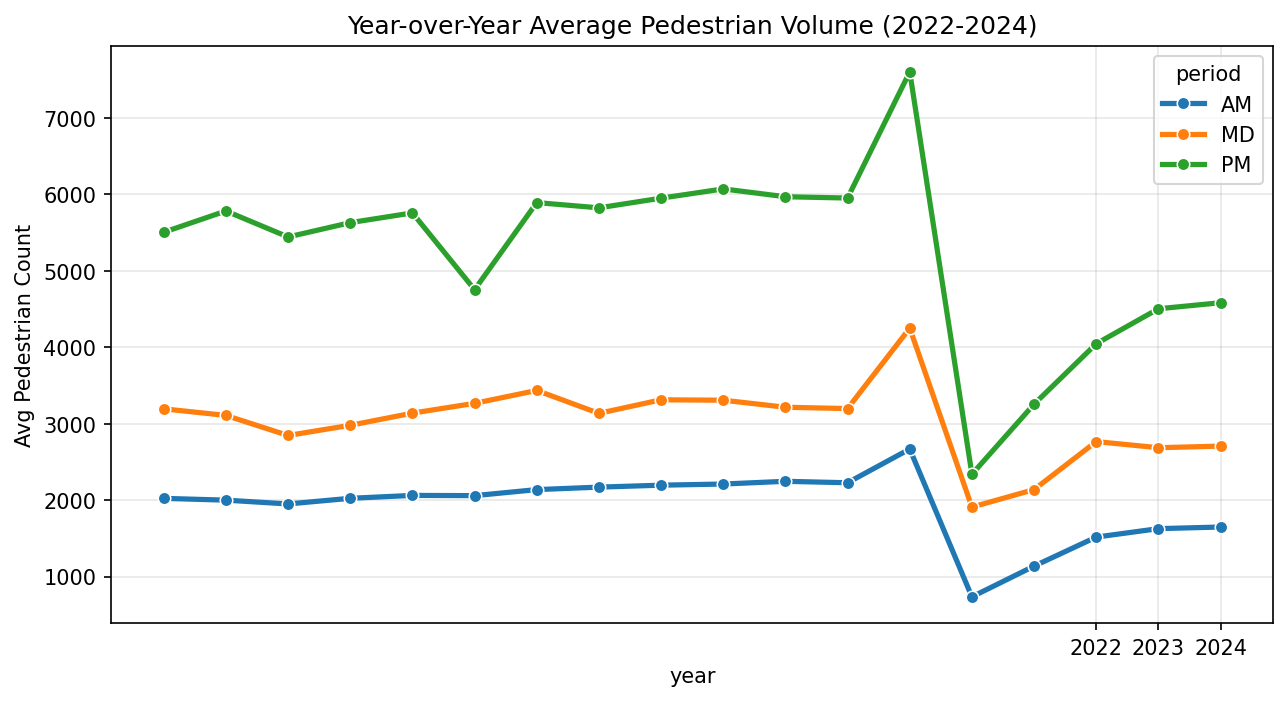


>>> Generating Bikeshare Usage Inequality Analysis...


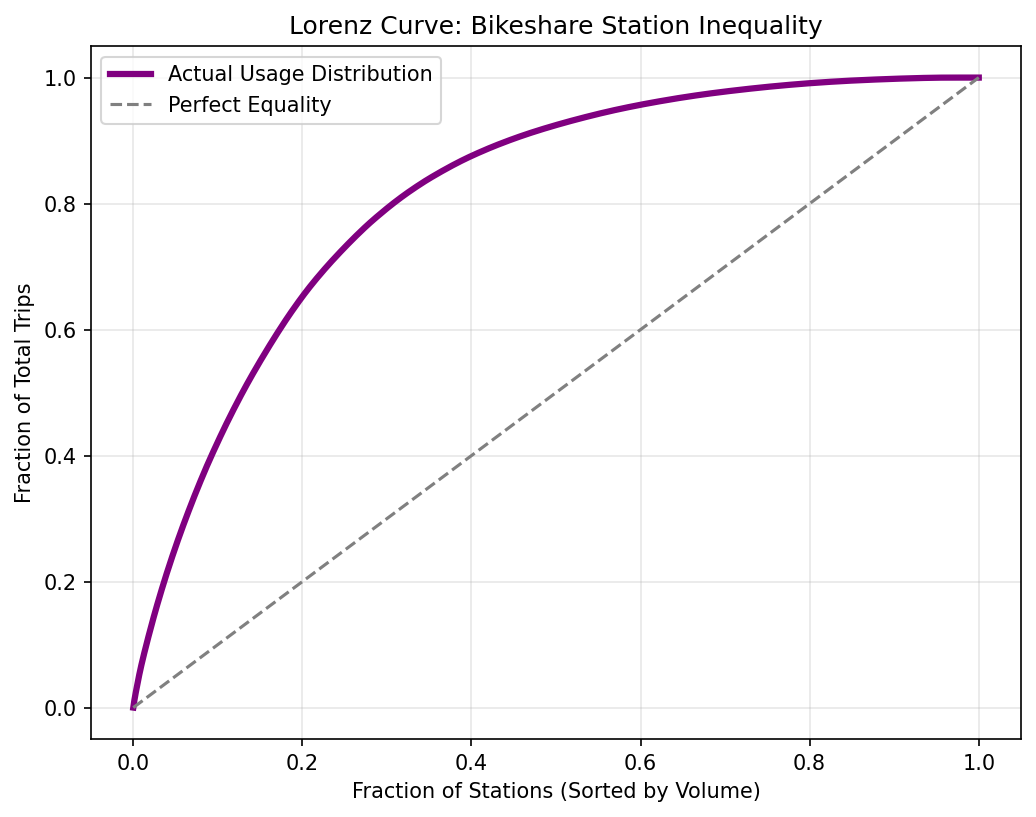


[Bikeshare Stats] Gini Coefficient: 0.629
Interpretaion: Higher Gini (>0.6) means the network relies heavily on a few 'Mega-Stations'.

>>> Generating Segmented Correlation Analysis...


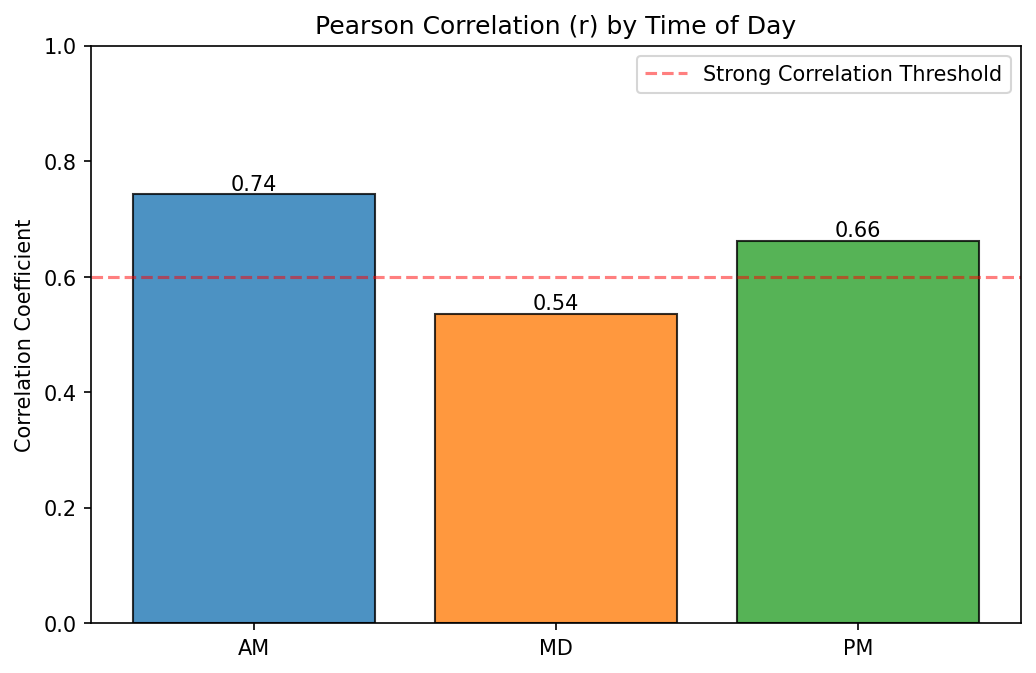


>>> Generating 'Conversion Efficiency' Analysis...


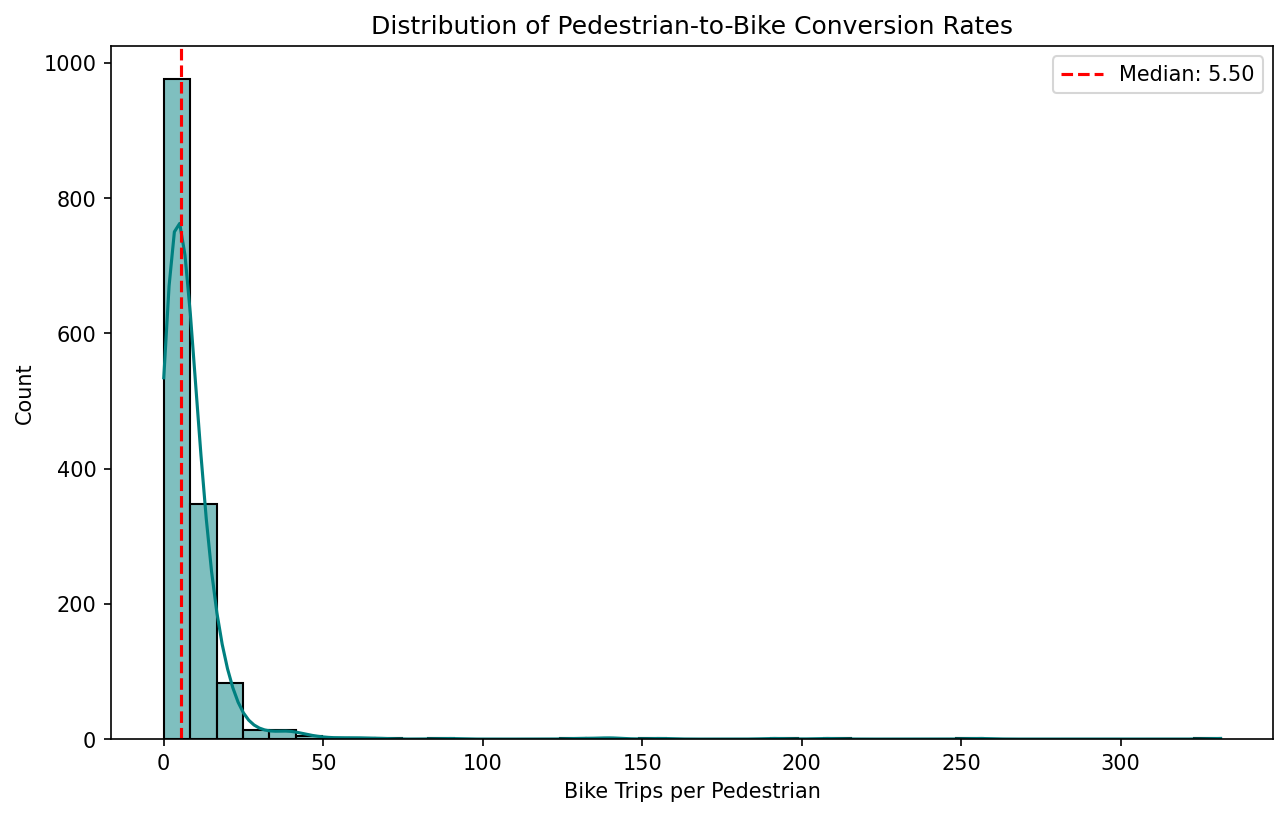


[Conversion Insight]
This chart defines 'normal'. Locations far to the left are under-performing;
locations far to the right are hyper-efficient / strong connectors.


In [6]:

deep_dive = DatasetDeepDive(nexus.ped_long, nexus.bike_agg, merged)
nyc_ghosts, nyc_workhorses = deep_dive.zscore_table(top_n=5)
nyc_ghosts_named = nyc_ghosts.copy()
nyc_ghosts_named['Location'] = nyc_ghosts_named['Loc'].map(loc_lookup)
print(nyc_ghosts_named)

# Existing analyses (unchanged)
deep_dive.analyze_pedestrian_distributions()
deep_dive.analyze_temporal_recovery()
deep_dive.analyze_station_inequality()
deep_dive.analyze_segmented_correlations()
deep_dive.analyze_the_efficiency_ratio()


>>> Layer 4: Structural Mismatch Identification (Z-Score Analysis)...

[TOP 10 'GHOST ZONES' (High Ped / Low Bike)]
Location                                 | Period | Ped Count  | Bike Trips | Gap Score
------------------------------------------------------------------------------------------
65                                       | MD     | 15490      | 21402      | 4.01
9                                        | MD     | 10699      | 1043       | 3.86
44                                       | MD     | 15618      | 25126      | 3.76
65                                       | MD     | 14168      | 19273      | 3.69
65                                       | MD     | 15831      | 27172      | 3.68
65                                       | MD     | 13164      | 20291      | 3.24
9                                        | PM     | 14631      | 2255       | 3.16
65                                       | MD     | 12336      | 18849      | 3.04
44                                      

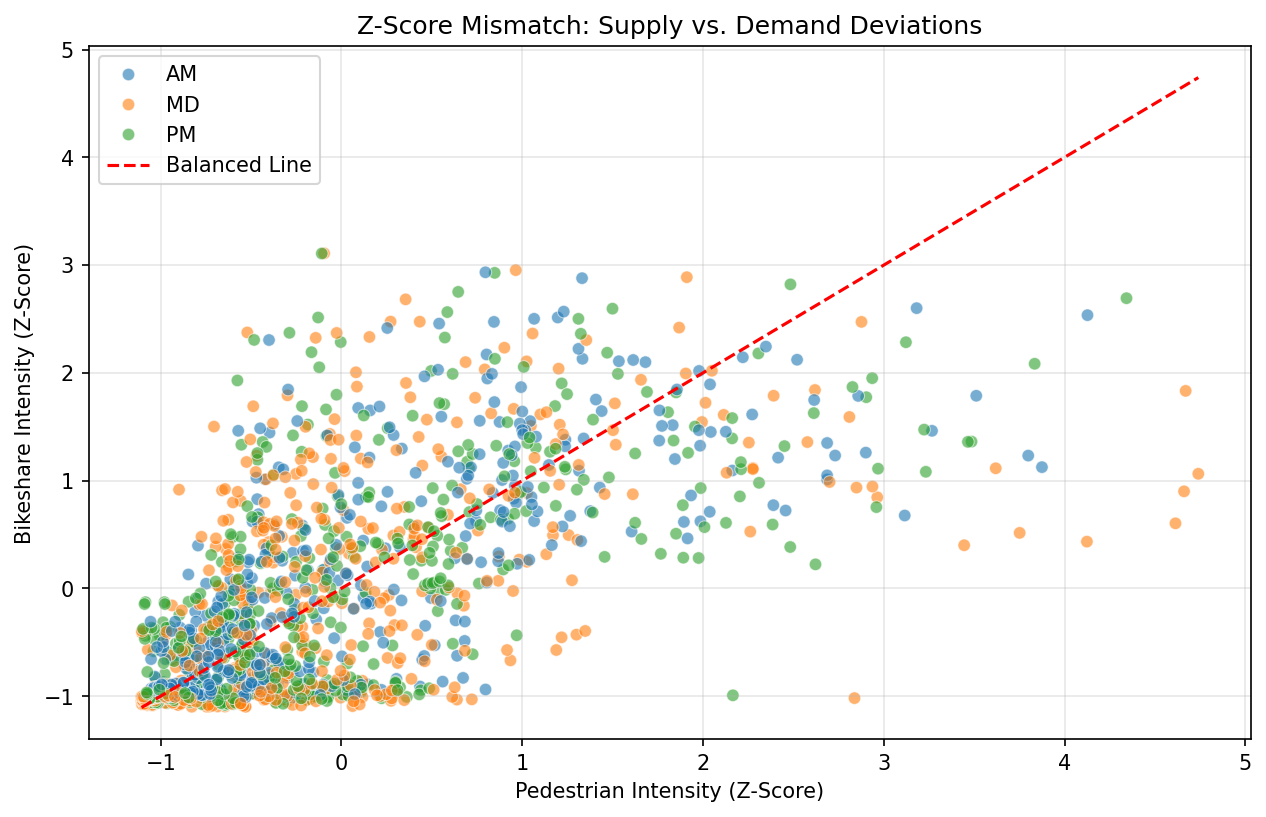


>>> Identifying Latent Demand Zones (Percentile-based)...
   -> Thresholds: ped_count >= 7458.8 (q=0.9), bike_activity <= 3638.6 (q=0.3)
   -> Found 2 high-ped / low-bike observations.


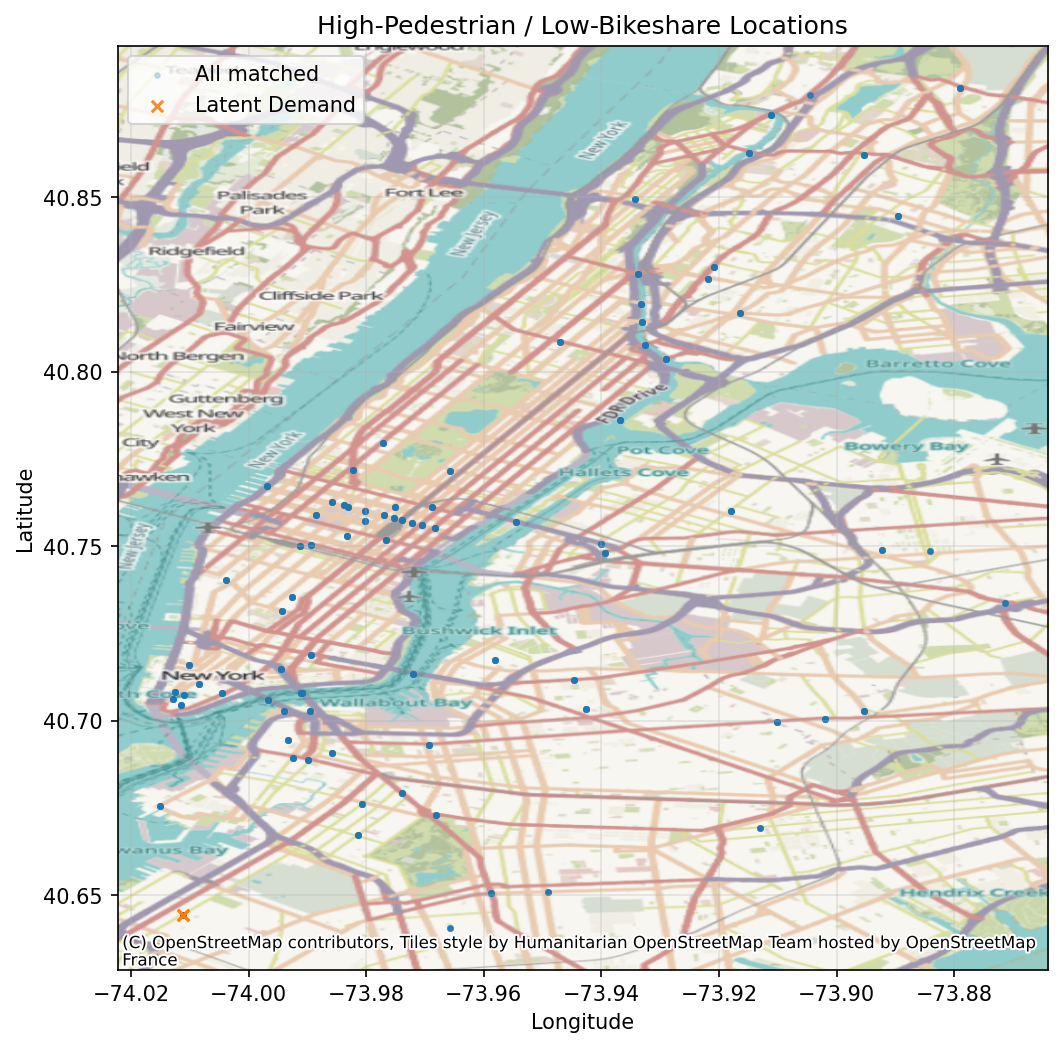

In [24]:
# Structural mismatches (now returns dataframes)
ghosts, workhorses = deep_dive.analyze_structural_mismatches(top_n=10)

# Latent demand among matched locations
latent_matched = deep_dive.identify_latent_demand_percentile(ped_q=0.9, bike_q=0.3)
deep_dive.plot_latent_demand_map(latent_matched)

# Enriched merged dataframe for the algorithm layer
enriched = deep_dive.get_enriched_merged(min_ped=50)

In [26]:
enriched.head()

Loc Street_Nam  year  month period  ped_count  bike_activity  station  \
0    1   Broadway  2024      6     AM      901.0          423.0       11   
1    1   Broadway  2024      6     MD     2052.0          661.0       11   
2    1   Broadway  2024      6     PM     3482.0         1343.0       11   
3    1   Broadway  2024     10     AM     1031.0          590.0       11   
4    1   Broadway  2024     10     MD     2229.0          610.0       11   

         lat        lon  conversion_rate     z_ped    z_bike  gap_score  
0  40.879199 -73.904591         0.469478 -0.560666 -0.984720   0.424054  
1  40.879199 -73.904591         0.322125 -0.366912 -1.048963   0.682051  
2  40.879199 -73.904591         0.385698 -0.330482 -1.029277   0.698794  
3  40.879199 -73.904591         0.572260 -0.484866 -0.972657   0.487791  
4  40.879199 -73.904591         0.273665 -0.301312 -1.053026   0.751714

In [27]:
enriched.columns

Index(['Loc', 'Street_Nam', 'year', 'month', 'period', 'ped_count',
       'bike_activity', 'station', 'lat', 'lon', 'conversion_rate', 'z_ped',
       'z_bike', 'gap_score'],
      dtype='object')

# FINAL ENGINE

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

class RepositioningMasterEngine:
    """
    Data-adaptive repositioning engine for bikeshare systems.

    Supports:
      • NYC-style sparse snapshot datasets
      • DC-style continuous hourly datasets
      • Arbitrary future cities with similar fields
    """

    # ------------------------------------------------------------------
    # INITIALIZATION & STANDARDIZATION
    # ------------------------------------------------------------------
    def __init__(
        self,
        df_enriched: pd.DataFrame,
        city_name: str | None = None,
        unmatched_ped: pd.DataFrame | None = None,
        accessibility: pd.DataFrame | None = None,
        ped_col: str | None = None,
        bike_col: str | None = None,
        loc_col: str | None = None,
        period_col: str = "period",
    ):
        self.city_name = city_name or "UnknownCity"
        self.raw = df_enriched.copy()

        self.unmatched_ped_raw = unmatched_ped.copy() if unmatched_ped is not None else None
        self.access_raw = accessibility.copy() if accessibility is not None else None

        # Auto-detect core columns
        self.ped_col = ped_col or self._detect_column(["ped_count", "Counts"])
        self.bike_col = bike_col or self._detect_column(["bike_activity"])
        self.loc_col = loc_col or self._detect_column(["Loc", "ped_station", "Station"])
        self.period_col = period_col if period_col in self.raw.columns else None

        # Main standardized working dataset
        self.df = self._standardize_df()

        # Optional external tables
        self.access_df = self._standardize_accessibility(self.access_raw)
        self.unmatched_ped_df = self._standardize_unmatched(self.unmatched_ped_raw)

        # Will be created by build_location_profiles()
        self.profiles = None

    def _detect_column(self, candidates):
        for c in candidates:
            if c in self.raw.columns:
                return c
        raise ValueError(f"None of {candidates} found among columns: {self.raw.columns.tolist()}")
    
    @staticmethod
    def format_table(df, cols=None, top_n=15, round_decimals=2):
        if df is None or df.empty:
            return pd.DataFrame()
        if cols is None:
            cols = [
                "location", "period_std",
                "ped_mean", "bike_mean", "conv_mean",
                "gap_mean", "frac_gap_hi", "frac_gap_lo",
                "undersupply_score", "oversupply_score"
            ]
        cols = [c for c in cols if c in df.columns]
        out = df[cols].head(top_n).copy()
        return out.round(round_decimals)

    def _standardize_df(self):
        """Creates consistent columns: ped, bike, location, period_std, z-scores, labels."""
        df = self.raw.copy()

        df["ped"] = df[self.ped_col].astype(float)
        df["bike"] = df[self.bike_col].astype(float)
        df["location"] = df[self.loc_col].astype(str)

        # Standard period
        df["period_std"] = (
            df[self.period_col].astype(str) if self.period_col else "ALL"
        )

        # Conversion rate
        df["conversion_rate"] = np.where(df["ped"] > 0, df["bike"] / df["ped"], np.nan)

        # Human-readable label
        if "Street_Nam" in df.columns:
            df["location_label"] = df["location"].astype(str) + " - " + df["Street_Nam"].astype(str)
        else:
            df["location_label"] = df["location"]

        # Z-scores per period
        def zt(x):
            std = x.std(ddof=0)
            return (x - x.mean()) / (std if std > 0 else 1)

        df["z_ped"] = df.groupby("period_std")["ped"].transform(zt)
        df["z_bike"] = df.groupby("period_std")["bike"].transform(zt)

        df["gap_score"] = df["z_ped"] - df["z_bike"]

        return df
    
        # --------------------------------------------------------------
    # MODERATE REALLOCATION ENGINE (Option B)
    # --------------------------------------------------------------
    def recommended_reallocation(self, df_original=None, total_shift_frac=0.10):
        """
        Compute a reallocation vector indicating bikes to add/remove per row,
        properly distributed across multiple observations per location-period.
        """
        if df_original is None:
            df = self.df.copy()
        else:
            df = df_original.copy()

        if self.profiles is None:
            self.build_location_profiles()

        prof = self.profiles.reset_index()

        # Total bikes and pool
        total_bikes = df["bike"].sum()
        pool = total_bikes * total_shift_frac

        # Normalize weights
        prof["under_w"] = prof["undersupply_score"].clip(lower=0)
        prof["over_w"] = prof["oversupply_score"].clip(lower=0)

        sum_under = prof["under_w"].sum()
        sum_over = prof["over_w"].sum()

        if sum_under == 0 or sum_over == 0:
            return pd.Series(0, index=df.index)

        # NET change per location-period (total bikes to add/remove)
        prof["net_change"] = (
            pool * (prof["under_w"] / sum_under) -
            pool * (prof["over_w"] / sum_over)
        )

        # Merge net_change back to df
        df = df.merge(
            prof[["location", "period_std", "net_change"]],
            on=["location", "period_std"],
            how="left"
        )
        df["net_change"] = df["net_change"].fillna(0)

        # Count rows per (location, period)
        df["n_rows"] = df.groupby(["location", "period_std"])["location"].transform("size")

        # Distribute the net change evenly across all rows
        df["reallocation"] = df["net_change"] / df["n_rows"]

        return df["reallocation"]



    # ------------------------------------------------------------------
    # OPTIONAL TABLES
    # ------------------------------------------------------------------
    def _standardize_accessibility(self, access_df):
        if access_df is None:
            return None
        df = access_df.copy()

        loc_col = next((c for c in ["Loc", "ped_station", "Station", "location"] if c in df.columns), None)
        if loc_col is None:
            return None

        df["location"] = df[loc_col].astype(str)

        if "dist_m" not in df.columns:
            if "dist_nearest_station_deg" in df.columns:
                df["dist_m"] = df["dist_nearest_station_deg"] * 111000
            else:
                df["dist_m"] = np.nan

        if "num_within_threshold" not in df.columns:
            df["num_within_threshold"] = np.nan

        return df[["location", "dist_m", "num_within_threshold"]].drop_duplicates()

    def _standardize_unmatched(self, unmatched_df):
        if unmatched_df is None:
            return None
        df = unmatched_df.copy()

        loc_col = next((c for c in ["Loc", "ped_station", "Station"] if c in df.columns), None)
        ped_col = next((c for c in ["ped_count", "Counts"] if c in df.columns), None)
        if loc_col is None or ped_col is None:
            return None

        df["location"] = df[loc_col].astype(str)
        df["ped"] = df[ped_col].astype(float)

        cols = ["location", "ped"]
        for c in ["lat", "lon"]:
            if c in df.columns:
                cols.append(c)

        return df[cols]

    # ------------------------------------------------------------------
    # BUILD LOCATION PROFILES
    # ------------------------------------------------------------------
    def build_location_profiles(self, gap_hi=1.0, gap_lo=-1.0, min_obs=3):
        df = self.df.copy()

        agg_dict = {
            "ped": "mean",
            "bike": "mean",
            "conversion_rate": "mean",
            "z_ped": "mean",
            "z_bike": "mean",
            "gap_score": "mean",
        }
        if "lat" in df.columns:
            agg_dict["lat"] = "mean"
        if "lon" in df.columns:
            agg_dict["lon"] = "mean"

        prof = df.groupby(["location", "period_std"]).agg(agg_dict).rename(
            columns={
                "ped": "ped_mean",
                "bike": "bike_mean",
                "conversion_rate": "conv_mean",
                "z_ped": "z_ped_mean",
                "z_bike": "z_bike_mean",
                "gap_score": "gap_mean",
            }
        )

        prof["n_obs"] = df.groupby(["location", "period_std"]).size()

        tmp = df.copy()
        tmp["is_hi"] = tmp["gap_score"] >= gap_hi
        tmp["is_lo"] = tmp["gap_score"] <= gap_lo

        prof["frac_gap_hi"] = tmp.groupby(["location", "period_std"])["is_hi"].mean()
        prof["frac_gap_lo"] = tmp.groupby(["location", "period_std"])["is_lo"].mean()

        # Scoring
        prof["undersupply_score"] = (
            np.maximum(prof["gap_mean"], 0)
            * prof["frac_gap_hi"].clip(lower=0)
            * np.log1p(prof["ped_mean"].clip(lower=0))
        )
        prof["oversupply_score"] = (
            np.maximum(-prof["gap_mean"], 0)
            * prof["frac_gap_lo"].clip(lower=0)
            * np.log1p(prof["bike_mean"].clip(lower=0))
        )

        # Minimum sample count
        prof = prof[prof["n_obs"] >= min_obs].copy()

        # Attach labels (this was the missing piece!)
        labels = df[["location", "location_label"]].drop_duplicates("location")
        prof = prof.reset_index().merge(labels, on="location", how="left")

        # Accessibility correction
        if self.access_df is not None:
            prof = prof.merge(self.access_df, on="location", how="left")

            dist_term = 1 + (prof["dist_m"].fillna(0) / 500)
            neigh_term = 1 + 1 / (1 + prof["num_within_threshold"].fillna(0))
            access_mult = dist_term * neigh_term

            prof["undersupply_score"] *= access_mult

        self.profiles = prof.set_index(["location", "period_std"])
        return self.profiles

    # ------------------------------------------------------------------
    # RANKING TABLES
    # ------------------------------------------------------------------
    def rank_undersupplied(self, top_n=20, min_score=0.0):
        if self.profiles is None:
            self.build_location_profiles()
        prof = self.profiles.reset_index()
        return prof[prof["undersupply_score"] > min_score].sort_values(
            "undersupply_score", ascending=False
        ).head(top_n)

    def rank_oversupplied(self, top_n=20, min_score=0.0):
        if self.profiles is None:
            self.build_location_profiles()
        prof = self.profiles.reset_index()
        return prof[prof["oversupply_score"] > min_score].sort_values(
            "oversupply_score", ascending=False
        ).head(top_n)

    # ------------------------------------------------------------------
    # NEW STATION CANDIDATES (if unmatched ped counters exist)
    # ------------------------------------------------------------------
    def rank_new_station_candidates(self, ped_quantile=0.9, min_obs=3):
        if self.unmatched_ped_df is None:
            print("No unmatched pedestrian data supplied.")
            return pd.DataFrame()

        df = self.unmatched_ped_df.copy()
        agg = df.groupby("location").agg(
            mean_ped=("ped", "mean"),
            n_obs=("ped", "size"),
            lat=("lat", "mean") if "lat" in df.columns else ("ped", "size"),
            lon=("lon", "mean") if "lon" in df.columns else ("ped", "size")
        )

        agg = agg[agg["n_obs"] >= min_obs]
        thr = agg["mean_ped"].quantile(ped_quantile)

        cand = agg[agg["mean_ped"] >= thr]
        cand["new_station_score"] = cand["mean_ped"] * np.log1p(cand["n_obs"])

        return cand.sort_values("new_station_score", ascending=False)

    # ------------------------------------------------------------------
    # VISUALIZATION
    # ------------------------------------------------------------------
    def plot_top_locations(self, mode="undersupplied", top_n=10):
        if self.profiles is None:
            self.build_location_profiles()

        col = "undersupply_score" if mode == "undersupplied" else "oversupply_score"
        prof = self.profiles.reset_index()

        df = prof.sort_values(col, ascending=False).head(top_n)
        if df.empty:
            print("No entries to plot.")
            return

        plt.figure(figsize=(10, 5))
        sns.barplot(data=df, x=col, y="location_label", hue="period_std", dodge=False)
        plt.title(f"{self.city_name}: Top {top_n} {mode.capitalize()} Locations")
        plt.xlabel("Score")
        plt.ylabel("Location")
        plt.tight_layout()
        plt.show()

    def plot_map(self, mode="undersupplied", top_n=50):
        if self.profiles is None:
            self.build_location_profiles()

        col = "undersupply_score" if mode == "undersupplied" else "oversupply_score"
        df = self.profiles.reset_index()

        if "lat" not in df.columns or "lon" not in df.columns:
            print("Missing lat/lon — cannot plot map.")
            return

        cand = df.sort_values(col, ascending=False).head(top_n)

        plt.figure(figsize=(8, 8))
        plt.scatter(df["lon"], df["lat"], s=5, alpha=0.2, label="All")

        plt.scatter(cand["lon"], cand["lat"], s=50, alpha=0.9, label=f"Top {mode}")
        for _, row in cand.iterrows():
            plt.annotate(
                f"{row['location_label']} ({row['period_std']})",
                (row["lon"], row["lat"]),
                fontsize=7, xytext=(5, 2), textcoords="offset points"
            )

        plt.title(f"{self.city_name}: Top {mode.capitalize()} Spatial Distribution")
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")
        plt.legend()
        plt.grid(alpha=0.3)
        plt.show()

    def plot_before_after_map(self, transformed_df, top_n=50):
        if self.profiles is None:
            self.build_location_profiles()

        before = self.df.groupby("location").agg({"bike": "mean", "lat": "mean", "lon": "mean"}).reset_index()
        after = transformed_df.groupby("location").agg({"bike": "mean", "lat": "mean", "lon": "mean"}).reset_index()

        merged = before.merge(after, on="location", suffixes=("_before", "_after"))
        merged["delta_bike"] = merged["bike_after"] - merged["bike_before"]

        selected = merged.sort_values("delta_bike", ascending=False).head(top_n)

        plt.figure(figsize=(14, 7))

        # BEFORE
        plt.subplot(1, 2, 1)
        plt.scatter(before["lon"], before["lat"], s=5, alpha=0.3)
        plt.scatter(
            selected["lon_before"], selected["lat_before"],
            s=40, c=selected["bike_before"], cmap="Blues"
        )
        plt.title("BEFORE Repositioning")
        plt.grid(alpha=0.3)

        # AFTER
        plt.subplot(1, 2, 2)
        plt.scatter(after["lon"], after["lat"], s=5, alpha=0.3)
        plt.scatter(
            selected["lon_after"], selected["lat_after"],
            s=40, c=selected["bike_after"], cmap="Greens"
        )
        plt.title("AFTER Repositioning")
        plt.grid(alpha=0.3)

        plt.tight_layout()
        plt.show()
        
    # --------------------------------------------------------------
    # COVERAGE IMPROVEMENT PANEL
    # --------------------------------------------------------------

    def coverage_improvement_panel(self, df_after, beta=1.0, top_n=15):
        """
        Highlights improvements between BEFORE vs AFTER repositioning.
        Uses raw (non-z-score) gap to show real imbalance.
        """

        before = self.df.copy()
        after = df_after.copy()

        # Compute RAW GAP
        before["raw_gap"] = before["ped"] - beta * before["bike"]
        after["raw_gap"]  = after["ped"]  - beta * after["bike"]

        # Station-level averages
        b = before.groupby("location")["raw_gap"].mean()
        a = after.groupby("location")["raw_gap"].mean()

        improvement = (b - a).sort_values(ascending=False)
        improvement_df = improvement.to_frame("raw_gap_reduction")
        improvement_df["gap_before"] = b
        improvement_df["gap_after"] = a

        # Compute network metrics
        # Compute thresholds for severe mismatch
        quant = before["raw_gap"].quantile(0.9)
        quant_neg = before["raw_gap"].quantile(0.1)

        # Severe undersupply: raw_gap well above typical
        severe_under_before = (before["raw_gap"] > quant).mean()
        severe_under_after  = (after["raw_gap"]  > quant).mean()

        # Severe oversupply: raw_gap well below typical
        severe_over_before  = (before["raw_gap"] < quant_neg).mean()
        severe_over_after   = (after["raw_gap"]  < quant_neg).mean()


        # Misallocation Index
        nmi_before = (before["raw_gap"].abs()).mean()
        nmi_after  = (after["raw_gap"].abs()).mean()

        # Gini improvement (bike supply)
        gini_before = self._gini(before["bike"])
        gini_after  = self._gini(after["bike"])

        # ---- PLOTS ----
        import matplotlib.pyplot as plt
        plt.figure(figsize=(12,5))

        plt.subplot(1,2,1)
        sns.kdeplot(before["raw_gap"], label="BEFORE", fill=True, alpha=0.3)
        sns.kdeplot(after["raw_gap"], label="AFTER", fill=True, alpha=0.3)
        plt.title("Raw Gap Distribution Shift")
        plt.xlabel("ped - β·bike")
        plt.legend()

        plt.subplot(1,2,2)
        sns.scatterplot(
            x=b, y=a, alpha=0.5
        )
        lim = [min(b.min(), a.min()), max(b.max(), a.max())]
        plt.plot(lim, lim, '--', color='black')
        plt.xlabel("Raw Gap Before")
        plt.ylabel("Raw Gap After")
        plt.title("Station-Level Improvement (Below Line = Better)")

        plt.tight_layout()
        plt.show()

        # ---- SUMMARY REPORT ----
        summary = {
            "Severe Undersupply Before": severe_under_before,
            "Severe Undersupply After": severe_under_after,
            "Severe Oversupply Before": severe_over_before,
            "Severe Oversupply After": severe_over_after,
            "Misallocation Index Before": nmi_before,
            "Misallocation Index After": nmi_after,
            "Bike Gini Before": gini_before,
            "Bike Gini After": gini_after,
        }

        return summary, improvement_df.sort_values("raw_gap_reduction", ascending=False).head(top_n)


    @staticmethod
    def _gini(x):
        # Safe Gini
        x = np.asarray(x).flatten()
        if np.amin(x) < 0:
            x -= np.amin(x)
        x += 1e-9
        x_sorted = np.sort(x)
        n = x.shape[0]
        return (2 * np.sum((np.arange(1, n+1) * x_sorted)) / (n * np.sum(x_sorted))) - (n + 1) / n



|     |   location | period_std   |   ped_mean |   bike_mean |   conv_mean |   gap_mean |   frac_gap_hi |   frac_gap_lo |   undersupply_score |   oversupply_score |
|----:|-----------:|:-------------|-----------:|------------:|------------:|-----------:|--------------:|--------------:|--------------------:|-------------------:|
| 201 |         65 | MD           |   13619.7  |    22092.2  |        1.65 |       3.26 |          1    |             0 |               31.05 |                  0 |
| 132 |         44 | MD           |   12071.8  |    29039    |        2.49 |       2.13 |          1    |             0 |               20.06 |                  0 |
| 173 |         57 | AM           |    7885.5  |    36495.5  |        4.66 |       1.89 |          1    |             0 |               16.97 |                  0 |
| 175 |         57 | PM           |   20727    |    71751.3  |        3.46 |       1.72 |          0.83 |             0 |               14.27 |                  0 |
| 240 |   

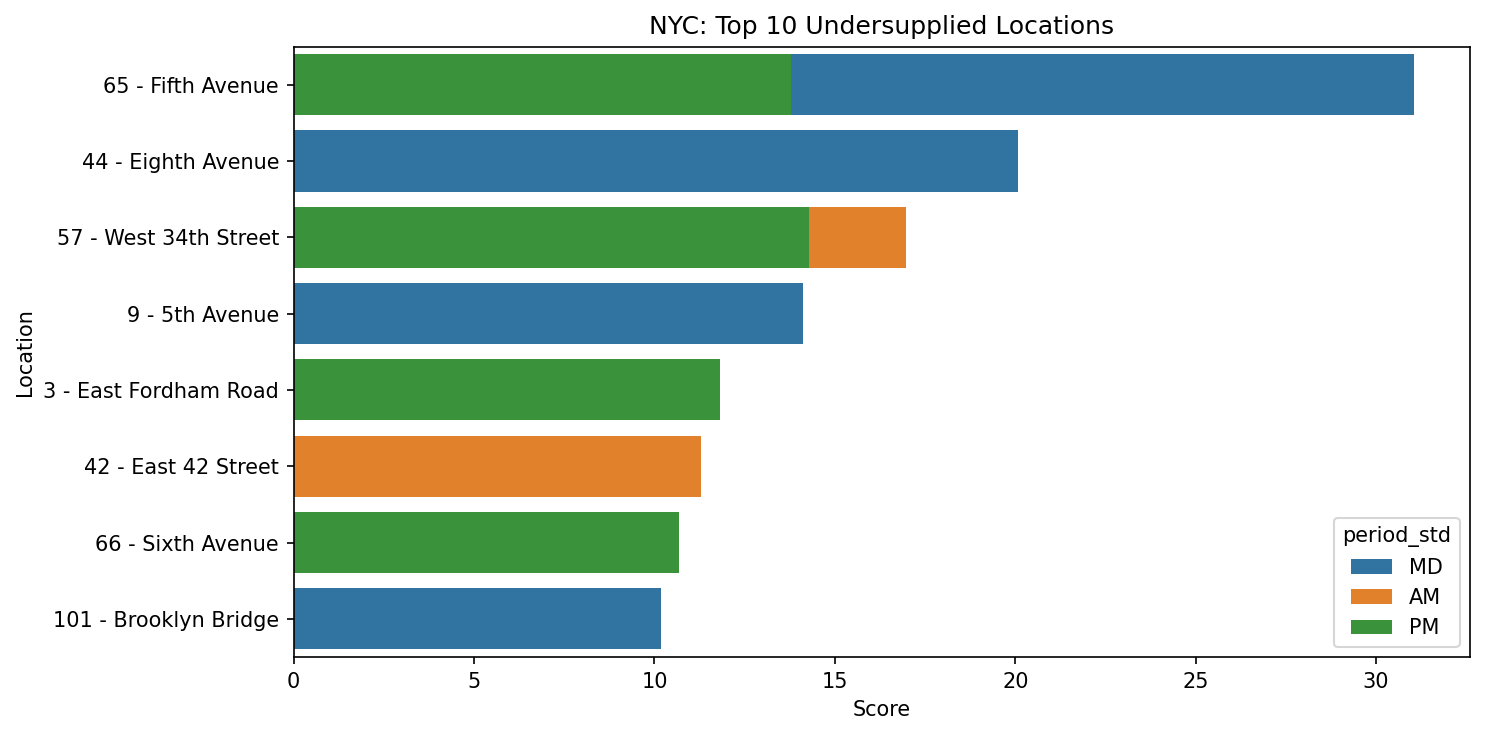

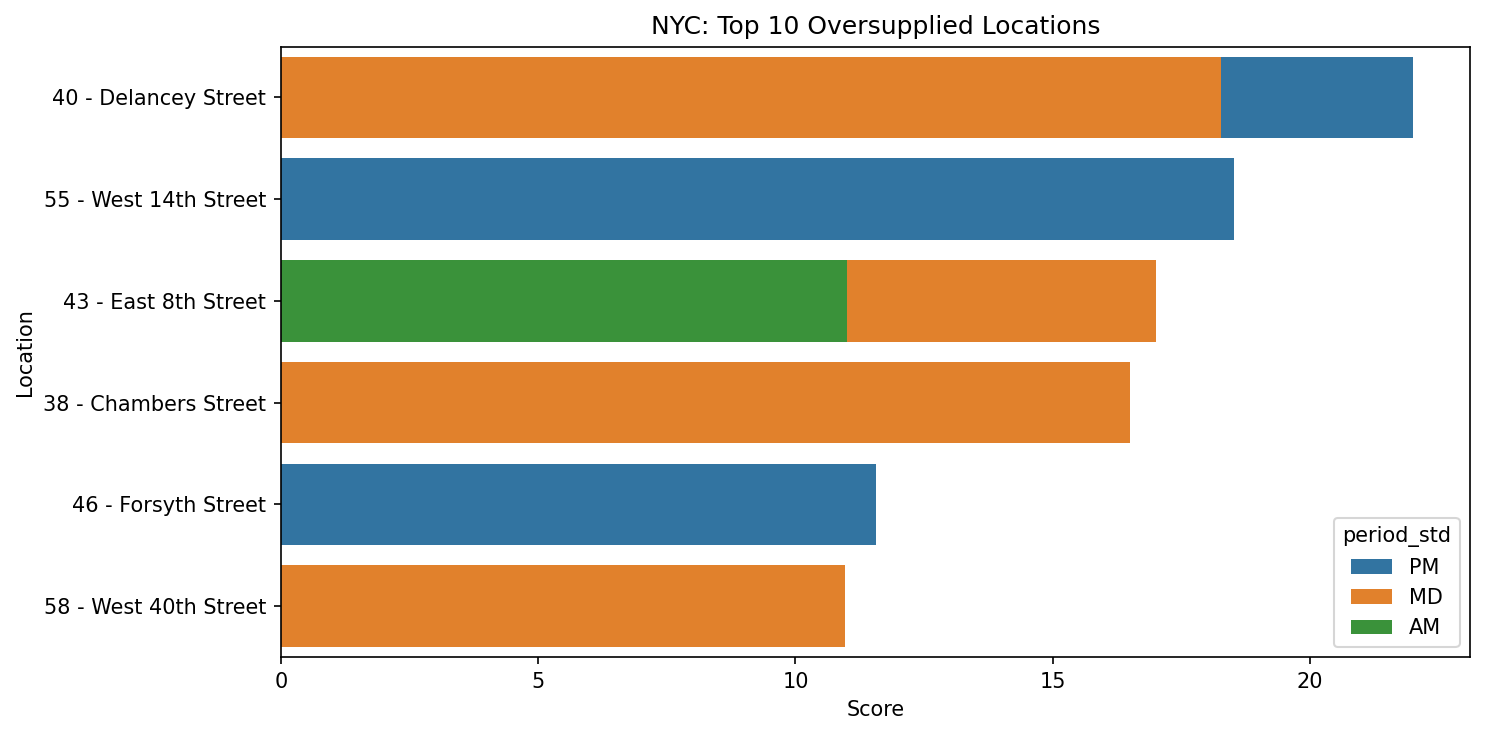

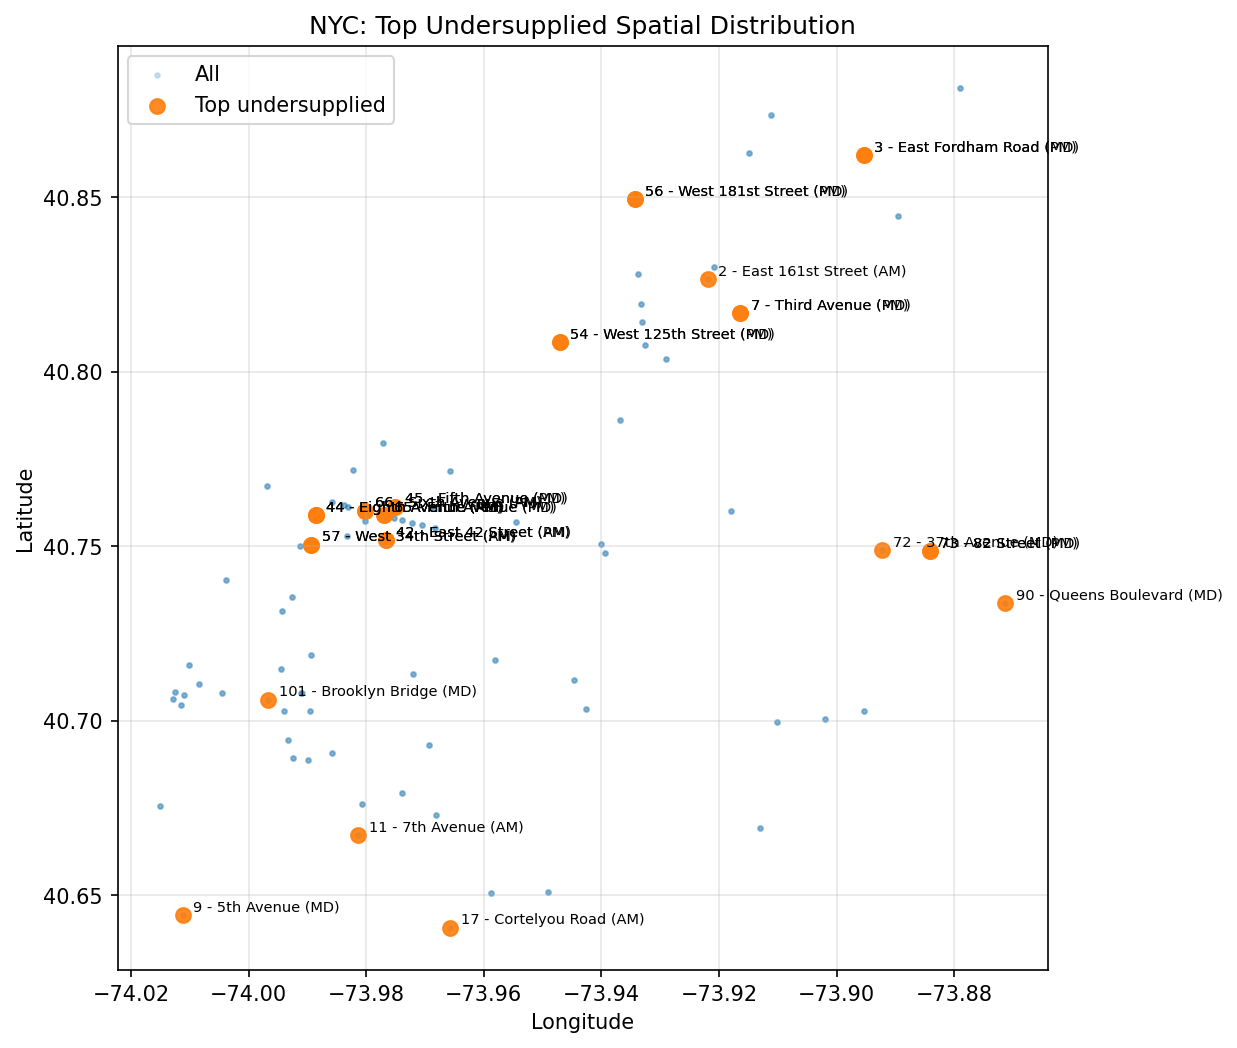

In [62]:
# df_nyc_enriched: your NYC enriched dataframe (the one with gap_score, etc.)
# nyc_unmatched: NYC ped counters with no nearby stations (if you kept them)
nyc_unmatched = nexus.unmatched_ped
nyc_engine = RepositioningMasterEngine(
    df_enriched=enriched,
    city_name="NYC",
    unmatched_ped=nyc_unmatched,   # or None if not available
    accessibility=None             # NYC doesn't have a clean access table yet
)

# Build profiles
nyc_profiles = nyc_engine.build_location_profiles(gap_hi=1.0, gap_lo=-1.0)

# Top undersupplied & oversupplied tables
nyc_under = nyc_engine.rank_undersupplied(top_n=15)
nyc_over  = nyc_engine.rank_oversupplied(top_n=15)
nyc_new   = nyc_engine.rank_new_station_candidates(ped_quantile=0.9)

# Pretty tables for your paper / slides
print(RepositioningMasterEngine.format_table(nyc_under).to_markdown())
print(RepositioningMasterEngine.format_table(nyc_over).to_markdown())
print(nyc_new.head(10).round(2).to_markdown())

# Visuals
nyc_engine.plot_top_locations(mode="undersupplied", top_n=10)
nyc_engine.plot_top_locations(mode="oversupplied", top_n=10)
nyc_engine.plot_map(mode="undersupplied", top_n=30)   # if lat/lon present


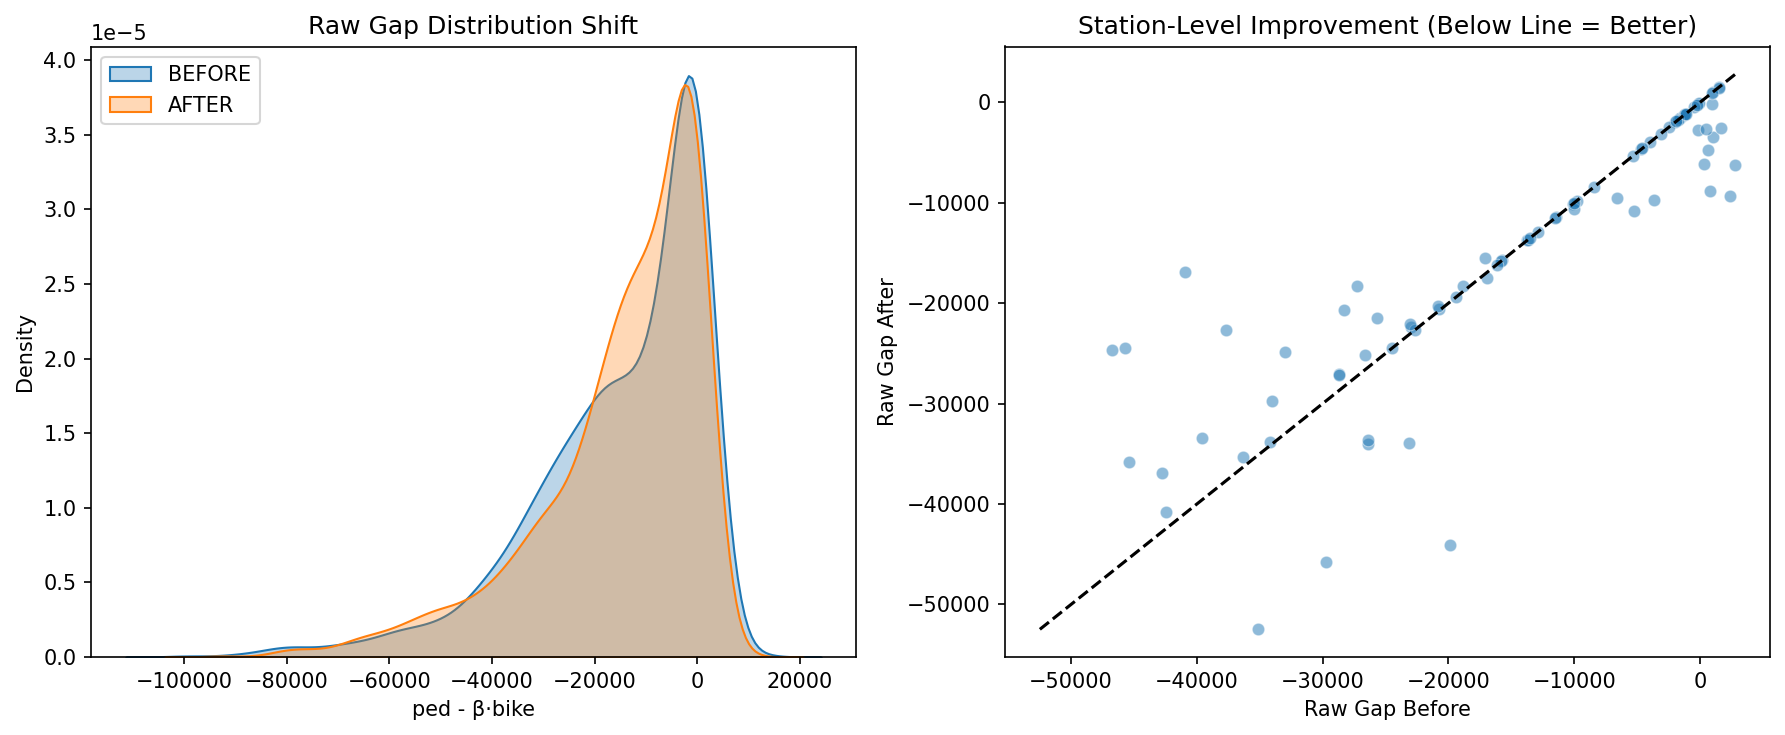

=== COVERAGE SUMMARY ===
Severe Undersupply Before: 0.1005
Severe Undersupply After: 0.0585
Severe Oversupply Before: 0.1005
Severe Oversupply After: 0.1032
Misallocation Index Before: 15365.9601
Misallocation Index After: 15173.0225
Bike Gini Before: 0.5430
Bike Gini After: 0.5299

=== TOP LOCATIONS WITH IMPROVEMENT ===
|   location |   raw_gap_reduction |   gap_before |   gap_after |
|-----------:|--------------------:|-------------:|------------:|
|         65 |            24206.6  |   -19899.1   |   -44105.7  |
|         57 |            17303.4  |   -35179     |   -52482.4  |
|         44 |            16018.9  |   -29745     |   -45763.9  |
|          3 |            11718.3  |     2375.06  |    -9343.2  |
|         42 |            10822    |   -23148.4   |   -33970.4  |
|         73 |             9674.71 |      819.111 |    -8855.6  |
|          9 |             9057.56 |     2798.33  |    -6259.23 |
|         45 |             7640.54 |   -26386.5   |   -34027.1  |
|         66 |   

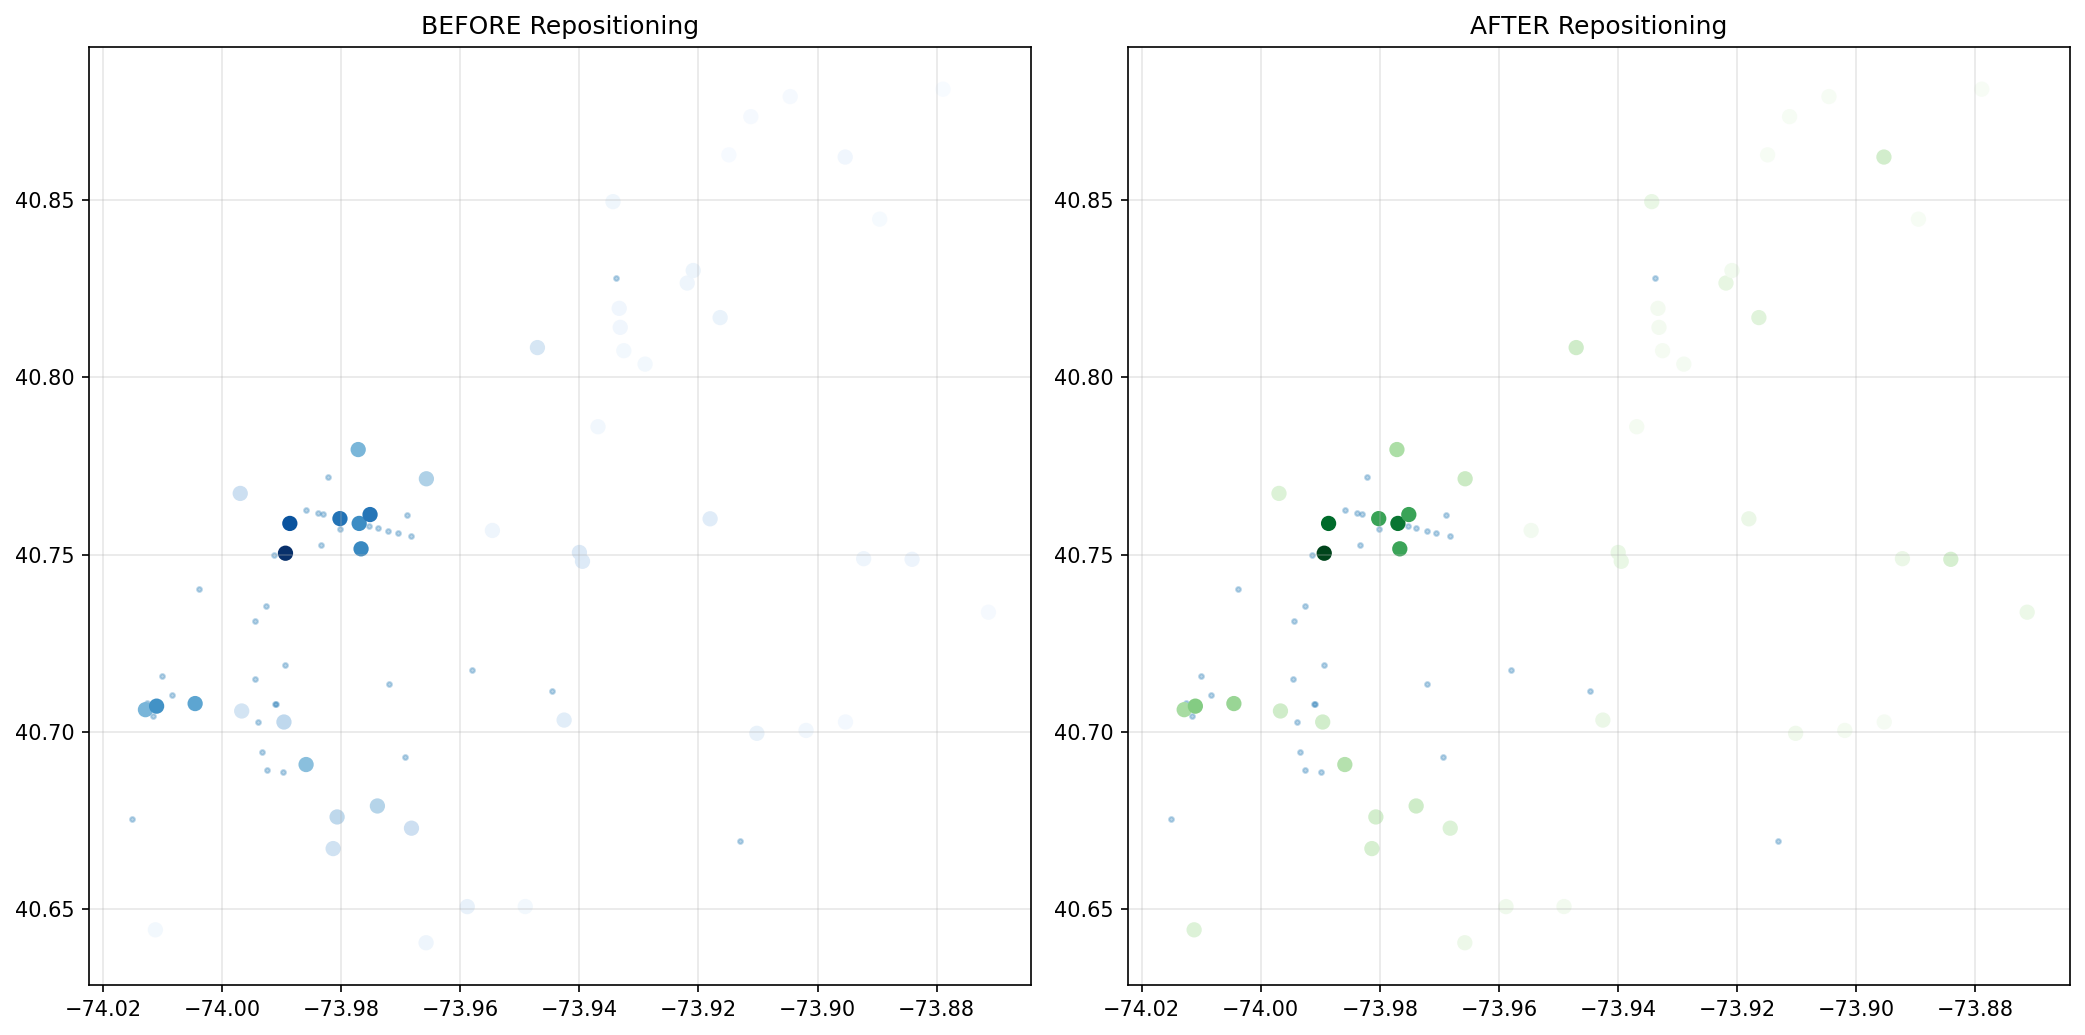

In [64]:
# Always operate on a clean, aligned index
df_original = nyc_engine.df.reset_index(drop=True)

# Compute reallocation
realloc = nyc_engine.recommended_reallocation(df_original).reset_index(drop=True)

# Apply transformation
df_after = df_original.copy()
df_after["bike"] = df_original["bike"] + realloc
df_after["bike"] = df_after["bike"].clip(lower=0)

# Coverage evaluation
summary, improvements = nyc_engine.coverage_improvement_panel(df_after)

print("=== COVERAGE SUMMARY ===")
for k, v in summary.items():
    print(f"{k}: {v:.4f}")

print("\n=== TOP LOCATIONS WITH IMPROVEMENT ===")
print(improvements.to_markdown())
nyc_engine.plot_before_after_map(df_after)
